<div align="center">
    <img src="https://upload.wikimedia.org/wikipedia/it/thumb/e/e2/Stemma_unipi.svg/900px-Stemma_unipi.svg.png?20221226121859" width="300px" alt="Logo University of Pisa">
</div>
<h1 align="center" style="height: 60px;"></h1>
<h1 align="center" style="height: 60px;">UNIVERSITY OF PISA</h1>
<h2 align="center" style="height: 60px;">MASTER’S DEGREE IN ARTIFICIAL INTELLIGENCE AND DATA ENGINEERING</h2>
<h3 align="center">Multimedia Information Retrieval and Computer Vision</h3>
<div style="height: 40px;"></div>
<h2 align="center">RAGING BULL Group</h2>
<div style="height: 80px;"></div>

<div style="display: flex; justify-content: space-around;">
    <div style="width:200px;">
        <p>Professor:</p>
        <ul>
            <li>Nicola Tonellotto</li>
        </ul>
    </div>
    <div style="width:200px;">
        <p>Students:</p>
        <ul>
            <li>Cleto Pellegrino</li>
            <li>Giuseppe Soriano</li>
            <li>Massimiliano Romani</li>
            <li>Francesco Boldrini</li>
        </ul>
    </div>
</div>
<div style="height: 80px;"></div>
<hr>
<h3 align="center">A.Y. 2024/2025</h3>
<hr>

<h1 align="center">Introduction</h1>

The scope of this project is to create and evaluate a search engine, using what was teached during the lectures. To ensure to have the maximum compatibility with every Notebook manager, in the following block of code there is the installation of all the packages that will be used in this project.

In [1]:
# Install necessary packages for text preprocessing, information retrieval, and data analysis.
%pip install -q nltk wordninja python-terrier ir-measures numpy pandas matplotlib scipy tqdm joblib polars requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importazioni necessarie
import re
import string
import nltk
import gc
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import math
from functools import lru_cache
import unicodedata
import wordninja
from collections import defaultdict, Counter
from tqdm import tqdm
import heapq
import pandas as pd
import requests
import tarfile
import os
import polars as pl
import joblib
import time
import matplotlib.pyplot as plt
import pyterrier as pt
import ir_measures
from ir_measures import *

environment = 'local'  # Set to 'colab' if running on Google Colab, 'local' otherwise

if environment == 'colab':
    %pip install gdown --quiet
    
    directory_id = "1_uoH2L8V9RUqHG5G3O9bX_AuYTtuyQfM"
    
    !gdown --id {directory_id} -O Files.zip
    
    !unzip -q Files.zip -d .

timing_results = []

def profile(f):
    """
    Decorator to measure the execution time of a function.

    Parameters:
        f (function): The function to be profiled.

    Returns:
        function: The wrapped function, which records its execution time (in milliseconds) in `timing_results`.
    """
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        timing_results.append(ms)  # Store execution time
        return result
    return f_timer

## Setup: Enabling Garbage Collector and Configuring NLTK Stopwords

### 1. Enabling Garbage Collector
- **Code:** `gc.enable()`
- **Purpose:** Ensures that the garbage collector (GC) is active to manage memory usage efficiently during runtime. This is especially useful when working with large datasets or computationally intensive tasks.
- **How it works:**
  - The `gc` module automatically frees up memory by deleting unused or unreachable objects in Python.
  - Explicitly enabling the GC ensures better memory management during text processing.

### 2. Downloading NLTK Stopwords
- **Code:** `nltk.download('stopwords', quiet=True)`
- **Purpose:** Downloads the NLTK corpus of stopwords (common words like "and", "the", "is") which are removed during preprocessing to reduce noise.
- **Why `quiet=True`:** Suppresses verbose output during the download process to maintain a cleaner log in the notebook.

### 3. Configuring Snowball Stemmer and Stopwords
- **Code:** 
  - `STEMMER = SnowballStemmer("english")`
  - `STOPWORDS = set(stopwords.words("english"))`
- **Purpose:** 
  - **Stemmer:** Reduces words to their root form (e.g., "running" → "run"), helping normalize text for better analysis.
  - **Stopwords:** Defines a set of stopwords in English to filter out during text preprocessing.
- **Details:**
  - The `SnowballStemmer` is a part of the NLTK library, known for its effectiveness in stemming for multiple languages.
  - `stopwords.words("english")` fetches a predefined list of English stopwords.

In [3]:
# Enable garbage collection to optimize memory management
gc.enable()

# Download stopwords for text preprocessing (quiet mode to suppress output)
nltk.download('stopwords', quiet=True)

# Initialize Snowball Stemmer for English
STEMMER = SnowballStemmer("english")

# Load English stopwords as a set for efficient lookups
STOPWORDS = set(stopwords.words("english"))


## Text Preprocessing: Regex Definitions
In this cell, several regular expressions (regex) are defined to clean and standardize the input text. These regex patterns help identify and process specific text structures commonly found in raw data.

### 1. Handling Acronyms
- **Regex:** `ACRONYM_RE = re.compile(r"\b(?:[A-Za-z]\.){2,}")`
- **Purpose:** Detects acronyms such as "U.S.A." and transforms them into "USA". 
- **How it works:**
  - Matches sequences of two or more single letters followed by a dot (`.`).
  - Ensures these patterns are identified as part of the same word.

### 2. Removing URLs and Emails
- **Regex for URLs:**
  - `HTTP_REGEX = re.compile(r"\s?http\S+")` matches strings starting with `http` followed by any non-whitespace characters.
  - `WWW_REGEX = re.compile(r"\s?www\S+")` matches strings starting with `www` followed by any non-whitespace characters.
- **Regex for Emails:**
  - `EMAIL_REGEX = re.compile(r"\S+@\S+")` matches strings containing an email structure with an "@" symbol separating two sequences.
- **Purpose:** Removes unwanted links and email addresses from the text, which are irrelevant for the information retrieval task.

### 3. Removing Punctuation
- **Variable:** `CLEAN_TABLE`
- **Purpose:** Replaces all punctuation marks in the text with spaces. This is useful for tokenization and ensures that punctuation does not interfere with text processing.
- **How it works:**
  - Uses `str.maketrans` to create a translation table that maps each punctuation character to a space.
  - The length of the replacement (`" " * len(string.punctuation)`) ensures every punctuation mark is consistently replaced by a single space.


In [4]:
# Regex patterns for text preprocessing
# - ACRONYM_RE: Matches acronyms (e.g., "U.S.A.") and removes periods.
ACRONYM_RE = re.compile(r"\b(?:[A-Za-z]\.){2,}")

# - HTTP_REGEX: Matches and removes URLs starting with "http".
HTTP_REGEX = re.compile(r"\s?http\S+")

# - WWW_REGEX: Matches and removes URLs starting with "www".
WWW_REGEX = re.compile(r"\s?www\S+")

# - EMAIL_REGEX: Matches and removes email addresses.
EMAIL_REGEX = re.compile(r"\S+@\S+")

# Translation table for removing punctuation
# Replaces punctuation with spaces for cleaner tokenization.
CLEAN_TABLE = str.maketrans(string.punctuation, " " * len(string.punctuation))


## Text Preprocessing Function
This section contains the implementation of a comprehensive text preprocessing function. The goal is to clean and standardize input text by removing noise, normalizing, tokenizing, and stemming words while handling specific cases like acronyms and long compound words.

### 1. Caching with `@lru_cache`
- **Purpose:** The `@lru_cache` decorator optimizes the `stem_word` and `split_word` functions by caching their results. This is particularly useful when the same words are repeatedly processed, as it reduces redundant computations and improves efficiency.
- **Details:**
  - `stem_word(word)`: Stems the input word using the pre-configured `STEMMER`. Stemming through `SnowballStemmer` helps reduce words to their root forms for better analysis (e.g. "playing" → "play", "ran" → "run").
  - `split_word(word)`: Splits compound words (e.g., "machinelearning") into individual tokens using the `wordninja` library. This is applied only to words longer than 10 characters for efficiency.

### 2. Text Normalization and Encoding
- **Code:** `unicodedata.normalize("NFKD", text).encode('ASCII', 'ignore').decode("utf-8").lower()`
- **Purpose:** Normalizes text by:
  - Converting Unicode characters into their decomposed forms.
  - Stripping diacritics and special characters.
  - Encoding into ASCII format and decoding to UTF-8 to ensure compatibility.
  - Lowercasing all text for uniformity.
  
  <p>Basically it changes composite symbols into their separate forms in the specific order established by the <b>Normalization form</b>, like in the example below: </br></p> 
            <img src="https://unicode.org/reports/tr15/images/UAX15-NormFig6.jpg" style="width:450px;">
            <p>in this case, the <b>NFKD</b> (Normalisation Form: Compatibility Decomposition) option was chosen, which means that characters are decomposed, in order to obtain the base forms of the characters composing the original character, from the point of view of compatibility between characters. Two characters are compatible if they have the same significance even if the style form or the usage is different. This differs from Canonicity, in which two characters have the same significance from semantic and visual point of view, but the codes are different.</p>

### 3. Regex-Based Cleaning
- **Purpose:** Removes unnecessary elements like acronyms, URLs, and email addresses using predefined regex patterns:
  - **Acronyms:** `ACRONYM_RE.sub(lambda x: x.group().replace('.', ''), text)` converts acronyms like "U.S.A." to "USA".
  - **URLs and Emails:** Substitutes them with whitespace to avoid interference in text analysis.

### 4. Removing Punctuation
- **Code:** `text.translate(CLEAN_TABLE)`
- **Purpose:** Uses a translation table to replace punctuation marks with spaces. This ensures punctuation does not interfere with tokenization or word matching.

### 5. Tokenization and Stopword Removal
- **Process:**
  - Splits text into words using `text.strip().split()`.
  - Avoids consecutive duplicates by comparing each token with the previous one.
  - Applies `split_word` for long tokens to ensure better granularity.
  - Filters out stopwords using the pre-configured `STOPWORDS` set.
  - Stems remaining words using `stem_word` to reduce them to their base forms.

### 6. Returning Preprocessed Tokens
- **Final Output:** Returns a list of tokens that:
  - Are clean, normalized, and lowercase.
  - Do not contain stopwords or punctuation.
  - Have been reduced to their root forms for better analysis.

In [5]:
@lru_cache(maxsize=None)
def stem_word(word):
    """
    Stems a single word.

    Parameters:
        word (str): The word to be stemmed.

    Returns:
        str: The stemmed version of the word.
    """
    return STEMMER.stem(word)

@lru_cache(maxsize=None)
def split_word(word):
    """
    Splits a long word into smaller components.

    Parameters:
        word (str): A word, typically longer than 10 characters.

    Returns:
        list[str]: List of sub-words.
    """
    return wordninja.split(word)

def preprocess(text):
    """
    Cleans, normalizes, tokenizes, and stems the input text.

    Parameters:
        text (str): Input text to preprocess.

    Returns:
        list[str]: Preprocessed and stemmed tokens.
    """
    # Normalize and encode text
    text = unicodedata.normalize("NFKD", text).encode('ASCII', 'ignore').decode("utf-8").lower()

    # Remove acronyms, URLs, emails, and other unwanted patterns
    text = ACRONYM_RE.sub(lambda x: x.group().replace('.', ''), text)
    text = HTTP_REGEX.sub(' ', text)
    text = WWW_REGEX.sub(' ', text)
    text = EMAIL_REGEX.sub(' ', text)

    # Remove punctuation and non-essential characters
    text = text.translate(CLEAN_TABLE)

    # Tokenize, split long words, remove stopwords, and stem tokens
    words = text.strip().split()
    words_with_no_close_duplicate = []
    current = ""

    for word in words:
        if word != current:  # Skip consecutive duplicates
            splitted_words = split_word(word) if len(word) > 10 else [word]
            for splitted_word in splitted_words:
                if splitted_word not in STOPWORDS:
                    words_with_no_close_duplicate.append(stem_word(splitted_word))
            current = word

    return words_with_no_close_duplicate


## Building the Index
In this section, the process of building the `inverted index` is presented. The inverted index is a data structure holding, for each term/word, the list of documents and other informations in which the term/word appears. Informations about the document are stored in the data structure called **Posting List**, which holds the following informations:

- Identifier of the document
- Occurences of the term in the document (frequency)

It follows a detailed explanation of the process of building the inverted index.

### 1. Inputs
- **Dataset:** The input dataset is expected to have at least two columns:
  - `docno`: The unique document identifier.
  - `tokens`: A list of preprocessed tokens for each document.

### 2. Data Structures
The function creates and populates several indices:
- **Lexicon:** A dictionary mapping tokens to:
  - A unique term ID.
  - Document frequency (number of documents containing the term).
  - Term frequency (total occurrences of the term across all documents).
- **Inverted Index:** 
  - `inv_d`: Maps term IDs to the list of document IDs where the term appears.
  - `inv_f`: Maps term IDs to their corresponding frequencies in the documents.
- **Direct Index:** Maps document IDs to a dictionary of term IDs and their frequencies.
- **Document Index:** A list of tuples `(docid, doclen)` where:
  - `docid`: The document ID.
  - `doclen`: The number of tokens in the document.
- **Statistics:** A dictionary storing metadata about the collection:
  - `num_docs`: Total number of documents in the dataset.
  - `num_terms`: Total number of unique terms in the dataset.
  - `num_tokens`: Total number of tokens in the entire dataset.

### 3. Processing Workflow
The function processes the dataset row by row:
1. **Initialization:**
   - Variables `termid`, `dataset_size`, and `total_toks` are initialized to track term IDs, dataset size, and total token count, respectively.
2. **Token Frequency Calculation:**
   - Uses `Counter` to calculate term frequencies for tokens in each document.
3. **Lexicon Update:**
   - If a token is not in the lexicon, it assigns a new unique `termid`.
   - Updates document frequency and term frequency for each token.
4. **Inverted Index Update:**
   - Appends document IDs and term frequencies to `inv_d` and `inv_f`.
5. **Direct Index Update:**
   - Maps document IDs to a dictionary of term IDs and their term frequencies.
6. **Document Length:**
   - Computes and stores the number of tokens (`doclen`) for each document in the `doc_index`.
7. **Statistics Calculation:**
   - Updates global statistics, such as the total number of tokens.

### 4. Outputs
The function returns:
1. **Lexicon:** Dictionary containing term metadata.
2. **Inverted Index:** Contains mappings for document IDs (`docids`) and frequencies (`freqs`).
3. **Document Index:** Stores document IDs and their lengths.
4. **Direct Index:** Maps document IDs to token frequencies.
5. **Statistics:** Metadata summarizing the dataset.

In [6]:
tqdm.pandas(desc='Preprocessing...')

def build_index(dataset):
    """
    Constructs an inverted index and other supporting structures from the input dataset.

    Parameters:
        dataset (DataFrame): A pandas DataFrame with the following columns:
            - 'docno': Unique identifier for each document.
            - 'tokens': List of tokens for the document.

    Returns:
        tuple: A collection of indices and statistics:
            - lexicon (dict): Maps tokens to their metadata [termid, document frequency, term frequency].
            - inverted_index (dict): Contains document IDs ('docids') and term frequencies ('freqs').
            - doc_index (list): List of tuples (docid, doclen), where doclen is the number of tokens in each document.
            - direct_index (dict): Maps document IDs to term IDs and their term frequencies.
            - stats (dict): Summary statistics, including:
                - 'num_docs': Total number of documents.
                - 'num_terms': Total number of unique terms.
                - 'num_tokens': Total number of tokens across all documents.
    """
    lexicon = defaultdict(lambda: [0, 0, 0])  # [termid, document frequency, term frequency]
    doc_index = []
    direct_index = defaultdict(dict)
    inv_d, inv_f = defaultdict(list), defaultdict(list)

    # Support variables
    termid = 0
    dataset_size = dataset.shape[0]
    total_toks = 0

    for row in tqdm(dataset.itertuples(index=False), desc='Indexing', total=dataset_size):
        docid = row.docno
        tokens = row.tokens

        token_tf = Counter(tokens)

        for token, tf in token_tf.items():
            if token not in lexicon:
                lexicon[token][0] = termid
                termid += 1

            token_id = lexicon[token][0]
            inv_d[token_id].append(int(docid))
            inv_f[token_id].append(tf)
            direct_index[int(docid)][token_id] = tf
            lexicon[token][1] += 1  # Increment document frequency
            lexicon[token][2] += tf  # Increment term frequency

        doclen = len(tokens)
        doc_index.append((docid, doclen))
        total_toks += doclen

    stats = {
        'num_docs': dataset_size,
        'num_terms': len(lexicon),
        'num_tokens': total_toks,
    }

    return dict(lexicon), {'docids': dict(inv_d), 'freqs': dict(inv_f)}, doc_index, dict(direct_index), stats

## Download and Extract Dataset
This section defines a utility function to download and extract a dataset. It ensures the dataset is available locally and unpacks it if necessary.

### 1. Function: `download_and_extract_dataset`
- **Purpose:** Downloads a compressed dataset from a specified URL and extracts it into a local directory.
- **Arguments:**
  - `url` (str): The URL of the dataset to download.
  - `local_filename` (str): The name of the local file where the dataset will be saved.
  - `extract_path` (str): The directory where the dataset will be extracted.
- **Steps:**
  1. **Check if the file already exists:**
     - If the file doesn't exist locally, it downloads the dataset using a streaming approach for efficiency.
  2. **Extract the file:**
     - If the dataset is not already extracted, it decompresses the `.tar.gz` file into the specified directory.

### 2. Parameters for MSMARCO Dataset
- **URL:** `https://msmarco.z22.web.core.windows.net/msmarcoranking/collection.tar.gz`
  - Provides the location of the MSMARCO dataset, commonly used for information retrieval tasks.
- **Local Filename:** `collection.tar.gz`
  - Specifies the name of the downloaded file.
- **Extract Path:** `os.path.join(os.getcwd(), 'collection')`
  - Defines the directory where the dataset will be extracted.

### 3. Execution
- The function is executed to ensure the MSMARCO dataset is downloaded and unpacked:
  - Downloads the file if not present locally.
  - Extracts its contents into the `collection` directory.
- Provides status updates during the download and extraction processes to enhance user experience.

In [7]:
def download_and_extract_dataset(url, local_filename, extract_path):
    """
    Downloads and extracts a dataset if it is not already present locally.

    Parameters:
        url (str): URL of the dataset to download.
        local_filename (str): Local file name for the downloaded archive.
        extract_path (str): Directory where the dataset will be extracted.

    Behavior:
        - Downloads the dataset from the given URL if `local_filename` does not exist.
        - Extracts the contents of the downloaded archive to `extract_path` if not already extracted.
    """
    # Download the file if it does not already exist
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename}...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print("Download completed.")

    # Extract the file if it has not been extracted yet
    if not os.path.exists(extract_path):
        print(f"Extracting {local_filename} to {extract_path}...")
        with tarfile.open(local_filename, 'r:gz') as tar:
            tar.extractall(path=extract_path)
        print("Extraction completed.")

# Dataset parameters
url = 'https://msmarco.z22.web.core.windows.net/msmarcoranking/collection.tar.gz'
local_filename = 'collection.tar.gz'
extract_path = os.path.join(os.getcwd(), 'collection')

# Execute download and extraction
download_and_extract_dataset(url, local_filename, extract_path)

## InvertedIndex Class

The `InvertedIndex` class is designed to represent an inverted index data structure, commonly used in information retrieval systems. It enables efficient document retrieval based on term queries, supporting advanced scoring functions like BM25. The implementation also includes a nested iterator class, `PostingListIterator`, for traversing posting lists efficiently.

---

### **1. Nested Class: PostingListIterator**

The `PostingListIterator` is responsible for iterating through the posting lists associated with a term in the inverted index.

#### **Attributes:**
- `docids`: A list of document IDs where the term appears (e.g., `[1, 2, 20, ...]`).
- `freqs`: The term frequencies in the corresponding documents (e.g., `[15, 30, 4, ...]`).
- `doclens`: A dictionary mapping document IDs to their lengths (e.g., `{0: 30, 1: 20, ...}`).
- `N`: The total number of documents in the collection.
- `avgdl`: The average document length across the collection.
- `K`: A constant used in the BM25 formula.
- `B`: A parameter in BM25 controlling the impact of document length normalization.
- `pos`: The iterator's current position in the posting list.

#### **Methods:**
1. **`docid()`**:
   - Returns the `docid` at the current position.
   - If the iterator has reached the end of the posting list, it returns `math.inf`.

2. **`score()`**:
   - Computes the BM25 score for the current term in the context of its associated document.
   - Formula (simplified here):
      $$
      \text{BM25}(i) = \log \frac{N}{df_i} \cdot \frac{tf_i}{k \cdot ((1 - b) + b \cdot dl_i / avgdl) + tf_i}
      $$
      where:
      - $ tf_i $: Term frequency of $ i $ in the document.
      - $ df_i $: Document frequency of $ i $ (number of docs that contain $` i $).
      - $` dl_i `$: Document length.
      - $` avgdl `$: Average document length.
      - $` N `$: Total number of documents.
      - $` k, b `$: Hyperparameters controlling term saturation and length normalization.
   - Returns `math.inf` if the end of the posting list is reached.

3. **`next(target=None)`**:
   - Advances the iterator to the next position or to a specified `target` document ID.
   - If `target` is provided, it efficiently skips to the document ID equal to or greater than `target`.

4. **`is_end_list()`**:
   - Checks if the iterator has reached the end of the posting list.

5. **`len()`**:
   - Returns the total number of documents in the posting list.

---

### **2. InvertedIndex Constructor**

The `InvertedIndex` constructor initializes the class with essential components for building and managing an inverted index.

#### **Parameters:**
- `lex`: The lexicon mapping terms to their metadata, such as term ID and frequencies.
- `inv`: The inverted index storing:
  - `docids`: A mapping of term IDs to lists of document IDs.
  - `freqs`: A mapping of term IDs to lists of term frequencies in the documents.
- `doc`: The document index containing tuples `(docid, doclen)` for all documents.
- `direct`: The direct index mapping document IDs to term frequency dictionaries.
- `stats`: A dictionary storing global collection statistics (e.g., total number of documents).
- `k`: The `k` parameter in the BM25 scoring formula.
- `b`: The `b` parameter in the BM25 scoring formula.

#### **Attributes:**
- `lexicon`: Stores the term metadata.
- `inv`: The inverted index structure.
- `doc`: The document index.
- `direct`: The direct index.
- `stats`: Collection statistics.
- `N`: Total number of documents, derived from `stats`.
- `doclens`: A dictionary mapping document IDs to their lengths.
- `avgdl`: The average document length across the collection.
- `K` and `B`: BM25 parameters for scoring.

---

### **3. Methods**

1. **`num_docs()`**:
   - Returns the total number of documents in the collection, derived from `stats['num_docs']`.

2. **`get_posting(termid)`**:
   - Retrieves the posting list for a specific term ID, returning a `PostingListIterator` object.
   - Uses `docids` and `freqs` from the inverted index to create the iterator.

3. **`get_termids(tokens)`**:
   - Converts a list of tokens into their corresponding term IDs using the `lexicon`.

4. **`get_postings(termids)`**:
   - Retrieves a list of posting lists for the provided term IDs.
   - Returns a list of `PostingListIterator` objects, one for each term ID.

In [8]:
class InvertedIndex:
    """
    Represents an inverted index for document retrieval.

    This class provides methods to manage the lexicon, inverted index, document index, and retrieval statistics.
    It also supports BM25 scoring for ranking documents based on term relevance.

    Attributes:
        lexicon (dict): Mapping of terms to metadata (e.g., term ID, frequencies).
        inv (dict): Inverted index containing 'docids' and 'freqs'.
        doc (list): Document index containing document IDs and their lengths.
        direct (dict): Direct index mapping document IDs to term IDs and their frequencies.
        stats (dict): Index statistics, including number of documents.
        N (int): Total number of documents in the collection.
        avgdl (float): Average document length.
        K (float): BM25 parameter for term frequency scaling.
        B (float): BM25 parameter for document length normalization.
    """

    class PostingListIterator:
        """
        Iterates over a posting list for a given term, supporting BM25 scoring.

        Attributes:
            docids (list): List of document IDs containing the term.
            freqs (list): Term frequencies in each document.
            doclens (dict): Mapping of document IDs to their lengths.
            N (int): Total number of documents.
            avgdl (float): Average document length.
            K (float): BM25 parameter for term frequency scaling.
            B (float): BM25 parameter for document length normalization.
        """
        def __init__(self, docids, freqs, doclens, N, avgdl, k, b):
            self.docids = docids
            self.freqs = freqs
            self.doclens = doclens
            self.N = N
            self.avgdl = avgdl
            self.K = k
            self.B = b
            self.pos = 0  # Current position in the posting list
            """
            Example:
                                       pos
                                        |
                                       -V-
                    self.docids = [1,   2,   20...]
            """

        def docid(self):
            """
            Returns the document ID at the current iterator position.

            Returns:
                int: The current document ID, or math.inf if the list has ended.
            """
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def score(self):
            """
            Computes the BM25 score for the current document.

            Returns:
                float: The BM25 score for the document, or math.inf if the list has ended.
            """
            if self.is_end_list():
                return math.inf

            tf_i = self.freqs[self.pos]
            dl_i = self.doclens.get(self.docid())
            df_i = self.len()

            return 0 if df_i == 0 else (tf_i / (self.K * ((1 - self.B) + self.B * dl_i / self.avgdl) + tf_i)) * math.log(self.N / df_i)

        def next(self, target=None):
            """
            Advances the iterator to the next position or to a target document ID.

            Parameters:
                target (int, optional): The target document ID to jump to. Defaults to None.
            """
            if not target:
                if not self.is_end_list():
                    self.pos += 1
            else:
                if target > self.docid():
                    try:
                        self.pos = self.docids.index(target, self.pos)
                    except ValueError:
                        self.pos = len(self.docids)

        def is_end_list(self):
            """
            Checks if the iterator has reached the end of the posting list.

            Returns:
                bool: True if the list has ended, False otherwise.
            """
            return self.pos == len(self.docids)

        def len(self):
            """
            Returns the length of the posting list.

            Returns:
                int: The number of documents in the posting list.
            """
            return len(self.docids)

    def __init__(self, lex, inv, doc, direct, stats, k, b):
        self.lexicon = lex
        self.inv = inv
        self.doc = doc
        self.direct = direct
        self.stats = stats
        self.N = self.num_docs()
        self.doclens = {int(doc_entry[0]): doc_entry[1] for doc_entry in self.doc}
        total_dl = sum(doc_entry[1] for doc_entry in self.doc)
        self.avgdl = total_dl / self.N
        self.K = k
        self.B = b

    def num_docs(self):
        """
        Returns the total number of documents.

        Returns:
            int: Total document count.
        """
        return self.stats['num_docs']

    def get_posting(self, termid):
        """
        Retrieves the posting list iterator for a given term ID.

        Parameters:
            termid (int): The ID of the term.

        Returns:
            PostingListIterator: An iterator for the term's posting list.
        """
        docids = self.inv['docids'].get(termid)
        freqs = self.inv['freqs'].get(termid)

        return InvertedIndex.PostingListIterator(
            docids=docids,
            freqs=freqs,
            doclens=self.doclens,
            N=self.N,
            avgdl=self.avgdl,
            k=self.K,
            b=self.B
        )

    def get_termids(self, tokens):
        """
        Retrieves the term IDs for a list of tokens.

        Parameters:
            tokens (list[str]): List of tokens.

        Returns:
            list[int]: List of term IDs.
        """
        return [self.lexicon[token][0] for token in tokens if token in self.lexicon]

    def get_postings(self, termids):
        """
        Retrieves the posting list iterators for a list of term IDs.

        Parameters:
            termids (list[int]): List of term IDs.

        Returns:
            list[PostingListIterator]: List of posting list iterators for the terms.
        """
        return [self.get_posting(termid) for termid in termids]


## TopQueue Class

The `TopQueue` class implements a priority queue designed to maintain the top-k elements based on their scores. This data structure is essential for efficiently managing and updating a limited set of the highest-scoring items, commonly used in information retrieval algorithms like Document-At-A-Time (DAAT).

---

### **Constructor: `__init__`**
Initializes the `TopQueue` instance with a maximum capacity and an optional initial threshold.

#### **Arguments:**
- `k` (int): Maximum capacity of the queue. Determines how many top items can be stored.
- `threshold` (float): The initial threshold score. Elements with scores below this value will not be inserted.

#### **Attributes:**
- `queue` (list): A min-heap that stores tuples of `(score, docid)`. The smallest score in the heap is at the root.
- `k` (int): Stores the maximum capacity of the queue.
- `threshold` (float): Tracks the minimum score required for an element to enter the queue.

---

### **Methods**

#### **1. `size()`**
Returns the current number of elements in the queue.

- **Purpose:** To check the size of the queue for logic decisions (e.g., determining if the queue is full).
- **Return Value:** An integer representing the number of items in the queue.

---

#### **2. `would_enter(score)`**
Determines whether a given score exceeds the current threshold and could be added to the queue.

- **Arguments:**
  - `score` (float): The score to evaluate against the threshold.
- **Returns:** 
  - `True` if the score exceeds the current threshold.
  - `False` otherwise.
- **Usage:** Used as a preliminary check to avoid unnecessary operations for scores that do not qualify.

---

#### **3. `clear(new_threshold=None)`**
Clears the queue and optionally updates the threshold to a new value.

- **Arguments:**
  - `new_threshold` (float): Optional. If provided, updates the queue's threshold to this new value.
- **Behavior:**
  - Resets the queue to an empty list.
  - Updates the `threshold` attribute if a new value is supplied.

---

#### **4. `__repr__()`**
Provides a string representation of the `TopQueue` instance for debugging and logging purposes.

- **Format:** 
  - Includes the number of items in the queue, the current threshold, and the contents of the queue.
  - Example: `<3 items, th=5.0 [(5.0, 1), (6.0, 2), (7.0, 3)]>`

---

#### **5. `insert(docid, score)`**
Attempts to insert a `(docid, score)` pair into the queue. The insertion only occurs if the score exceeds the threshold.

- **Arguments:**
  - `docid` (int): The unique identifier for the document.
  - `score` (float): The score associated with the document.
- **Returns:** 
  - `True` if the item is successfully inserted into the queue.
  - `False` if the item does not meet the threshold requirement.

- **Behavior:**
  1. Checks if the `score` exceeds the current threshold.
  2. If the queue has reached its maximum capacity (`k`):
     - Uses `heapq.heapreplace` to replace the root of the heap (smallest score) with the new `(score, docid)` pair if the score is higher.
  3. If the queue has not yet reached its capacity:
     - Uses `heapq.heappush` to add the new pair to the heap.
  4. Updates the `threshold`:
     - If the queue is at full capacity, the threshold is updated to the smallest score in the queue (`queue[0][0]`).

- **Heap Behavior:**
  - Maintains the heap property where the smallest score is always at the root, ensuring efficient management of the top-k items.

In [9]:
class TopQueue:
    """
    A priority queue to manage the top-k elements with a dynamic threshold.

    Attributes:
        queue (list): The internal priority queue storing (score, docid) tuples.
        k (int): Maximum capacity of the queue.
        threshold (float): Current threshold to determine if a new element enters the queue.
    """

    def __init__(self, k=10, threshold=0.0):
        """
        Initializes the queue with a maximum capacity and an initial threshold.

        Parameters:
            k (int): Maximum size of the queue. Defaults to 10.
            threshold (float): Initial threshold value. Defaults to 0.0.
        """
        self.queue = []
        self.k = k
        self.threshold = threshold

    def size(self):
        """
        Returns the number of elements in the queue.

        Returns:
            int: The current size of the queue.
        """
        return len(self.queue)

    def would_enter(self, score):
        """
        Checks if a score exceeds the current threshold.

        Parameters:
            score (float): The score to evaluate.

        Returns:
            bool: True if the score exceeds the threshold, False otherwise.
        """
        return score > self.threshold

    def clear(self, new_threshold=None):
        """
        Clears the queue and optionally updates the threshold.

        Parameters:
            new_threshold (float, optional): The new threshold value. Defaults to None.
        """
        self.queue = []
        if new_threshold is not None:
            self.threshold = new_threshold

    def __repr__(self):
        """
        Returns a string representation of the queue.

        Returns:
            str: A string describing the queue's state.
        """
        return f'<{self.size()} items, th={self.threshold} {self.queue}>'

    def insert(self, docid, score):
        """
        Inserts an element into the queue if the score exceeds the threshold.

        Parameters:
            docid (int): Document ID associated with the score.
            score (float): The score to insert.

        Returns:
            bool: True if the element was inserted, False otherwise.
        """
        if score > self.threshold:
            if self.size() >= self.k:
                heapq.heapreplace(self.queue, (score, docid))
            else:
                heapq.heappush(self.queue, (score, docid))
            if self.size() >= self.k:
                self.threshold = max(self.threshold, self.queue[0][0])
            return True
        return False


## Utility Method: `min_docid`

The `min_docid` method is a utility function used to find the smallest active document ID (`docid`) among a list of posting list iterators. It is an integral part of the Document-At-A-Time (DAAT) algorithm, as it helps determine the next document to process during query evaluation.

---

### **Arguments**
- `postings` (list): A list of posting list iterators. Each iterator provides access to a posting list containing:
  - Document IDs where a specific term appears.
  - Additional metadata such as term frequencies and scores.

---

### **Returns**
- **`int`:** The smallest active `docid` among the posting lists.
  - If all posting lists are exhausted, the function returns `math.inf`.

---

### **Workflow**
1. **Initialization:**
   - A variable `min_docid` is initialized to `math.inf` to represent the smallest document ID found so far. Using `math.inf` ensures that the comparison logic works seamlessly even if there are no active postings.

2. **Iteration Over Postings:**
   - For each posting list iterator in `postings`:
     1. **Check Active Status:** 
        - The function skips iterators that have reached the end of their posting list (determined by calling `is_end_list()`).
     2. **Update Minimum:** 
        - For active iterators, the function retrieves the current document ID using `docid()` and compares it with `min_docid`. The smaller value is retained.

3. **Return Value:**
   - After processing all iterators, the function returns the smallest `docid` found among the active posting lists. If no posting lists are active, the return value remains `math.inf`.

In [10]:
def min_docid(postings):
    """
    Finds the smallest active document ID (docid) among the provided postings.

    Parameters:
        postings (list[PostingListIterator]): List of posting list iterators.

    Returns:
        int: The smallest active document ID, or math.inf if all postings are exhausted.
    """
    min_docid = math.inf
    for p in postings:
        if not p.is_end_list():  # Check if the posting list has not been fully traversed
            min_docid = min(p.docid(), min_docid)
    return min_docid

## Document-At-A-Time (DAAT) Algorithm

The `daat` method implements the Document-At-A-Time (DAAT) algorithm, a common approach in information retrieval systems. This algorithm evaluates and ranks documents for a query by traversing multiple posting lists in a synchronized manner, processing one document ID (`docid`) at a time.

---

### **Arguments**
- `postings` (list): A list of posting list iterators, each corresponding to a term in the query. Each iterator provides:
  - Document IDs where the term appears.
  - Term-specific scores for the documents.
- `k` (int): The maximum number of top-ranked results to return. Defaults to `10`.

---

### **Returns**
- **`list`:** A list of tuples `(score, docid)` containing the top-k results, sorted in descending order by score. Each tuple represents:
  - `score`: The aggregated score for the document across all terms in the query.
  - `docid`: The document identifier.

---

### **Workflow**

#### **1. Initialize Data Structures**
- A `TopQueue` object (`top`) is created to maintain the top-k results during processing.
- The smallest active document ID across all posting lists is retrieved using the `min_docid(postings)` utility method and stored in `current_docid`.

#### **2. Process Each Document**
The algorithm iteratively evaluates documents in ascending order of their IDs (`docid`).

1. **Initialize Scores:**
   - For each `current_docid`, the initial score is set to `0`.
   - A variable `next_docid` is initialized to `math.inf` to track the next smallest `docid` to process.

2. **Aggregate Scores:**
   - For each posting list in `postings`:
     - If the posting list’s current document matches `current_docid`, its score is added to the aggregated score for the document, and the iterator advances to the next document.
     - If the posting list has additional documents, `next_docid` is updated to the minimum of its current `docid` and the existing value of `next_docid`.

3. **Insert into TopQueue:**
   - The `current_docid` and its aggregated score are inserted into the `TopQueue` object if the score meets the threshold.

4. **Advance to Next Document:**
   - Update `current_docid` to the value of `next_docid`.

#### **3. Termination**
- The process repeats until `current_docid` equals `math.inf`, indicating that all posting lists have been exhausted.

#### **4. Return Top Results**
- The contents of the `TopQueue` are sorted in descending order of scores and returned as the final result.

---

### **Algorithmic Considerations**

#### **Efficiency**
- **Time Complexity:**
  - For each document processed, the algorithm examines all posting lists, resulting in a complexity of $O(n \cdot m)$, where:
    - $n$ is the total number of documents across all posting lists.
    - $m$ is the number of posting lists.
- **Space Complexity:**
  - $O(k)$, as the `TopQueue` maintains only the top-k results.

#### **Benefits**
- By processing documents in ascending order of their IDs, DAAT minimizes the number of times each posting list is accessed, ensuring efficient query evaluation.
- The use of the `TopQueue` ensures that only the most relevant documents are retained, reducing memory usage.

---

### **Example**
Given the following posting lists:
- Posting 1: `(docid=1, score=3.0), (docid=3, score=2.0)`
- Posting 2: `(docid=1, score=1.5), (docid=2, score=4.0)`
- Posting 3: `(docid=2, score=2.5), (docid=3, score=1.0)`

For $k=2$, the `daat` function processes the documents as follows:
1. Aggregates scores for `docid=1`: $3.0 + 1.5 = 4.5$
2. Aggregates scores for `docid=2`: $4.0 + 2.5 = 6.5$
3. Aggregates scores for `docid=3`: $2.0 + 1.0 = 3.0$

The top-2 results returned are:
- `(6.5, docid=2)`
- `(4.5, docid=1)`

In [11]:
def daat(postings, k=10):
    """
    Implements the Document-At-A-Time (DAAT) algorithm for retrieving relevant documents.

    Parameters:
        postings (list[PostingListIterator]): List of posting list iterators, each representing a term's posting list.
        k (int): Maximum number of results to return. Defaults to 10.

    Returns:
        list[tuple]: A list of tuples (score, docid), sorted in descending order of score.
    """
    top = TopQueue(k)  # Priority queue to store the top-k results
    current_docid = min_docid(postings)  # Initialize with the smallest docid across all postings

    while current_docid != math.inf:
        score = 0
        next_docid = math.inf

        # Compute the score for the current document and find the next docid
        for posting in postings:
            if posting.docid() == current_docid:
                score += posting.score()
                posting.next()  # Move to the next position in the posting list
            if not posting.is_end_list():
                next_docid = min(posting.docid(), next_docid)

        # Insert the current document and its score into the top-k queue
        top.insert(current_docid, score)

        # Update to the next document ID to process
        current_docid = next_docid

    # Return the top-k results sorted by score in descending order
    return sorted(top.queue, reverse=True)

## Query Process Function: `query_process`

The `query_process` function is responsible for executing a search query on the inverted index and retrieving the top-k documents based on their relevance scores. It combines several components, including query tokenization, posting list retrieval, and ranking using the DAAT algorithm.

---

### **Arguments**
- `query` (str): The search query entered by the user. It is a raw text string that will be processed and evaluated against the inverted index.
- `index` (`InvertedIndex`): The inverted index object containing the necessary data structures, such as the lexicon, inverted lists, and document statistics.
- `k` (int): The maximum number of top-ranked documents to return. Defaults to `10`.

---

### **Returns**
- **`list`:** A list of tuples `(score, docid)` representing the top-k results. Each tuple contains:
  - `score`: The relevance score of the document for the query.
  - `docid`: The unique identifier of the document.

---

### **Workflow**

#### **1. Tokenization**
- The query string is split into individual terms using a text preprocessing function (e.g., stemming, stopword removal).
- The resulting tokens are normalized and made consistent with the terms used in the inverted index.

#### **2. Term-to-TermID Mapping**
- The function uses the index's `get_termids(tokens)` method to map each token in the query to its corresponding term ID.
- Only terms present in the lexicon are retained, ensuring that the function operates on valid data.

#### **3. Retrieve Posting Lists**
- For each valid term ID, the corresponding posting list is retrieved using the `index.get_postings(termids)` method.
- The posting lists contain information about which documents the term appears in, along with associated scores.

#### **4. DAAT Algorithm Execution**
- The `daat` function is called with the retrieved posting lists and the `k` parameter.
- The DAAT algorithm processes the posting lists to compute aggregate relevance scores for documents and ranks them based on these scores.

#### **5. Return Results**
- The sorted list of top-k `(score, docid)` tuples is returned as the final result.

---

### **Algorithmic Considerations**

#### **Efficiency**
- The method leverages the DAAT algorithm, which ensures efficient traversal of posting lists and minimizes redundant computations.
- By mapping terms to term IDs upfront, the function reduces the overhead of repeated lookups in the lexicon.

#### **Error Handling**
- If the query contains no valid terms (e.g., all tokens are stopwords), the function returns an empty list.

---

### **Example**
Given a query `"machine learning models"` and the following inverted index:
- Term "machine": Appears in documents `[1, 3]`
- Term "learning": Appears in documents `[2, 3]`
- Term "models": Appears in documents `[1, 2, 3]`

The function processes the query as follows:
1. **Tokenization:** `["machine", "learning", "models"]`
2. **Mapping to Term IDs:** `[101, 102, 103]`
3. **Retrieve Posting Lists:**
   - Term ID `101`: Documents `[1, 3]`
   - Term ID `102`: Documents `[2, 3]`
   - Term ID `103`: Documents `[1, 2, 3]`
4. **DAAT Execution:** Computes aggregated scores for each document.
5. **Return Results:** Returns the top-k results sorted by relevance, e.g., `[(score=8.5, docid=3), (score=7.0, docid=1)]`.

In [12]:
def query_process(query, index, heap_size=10):
    """
    Processes a text query and retrieves the most relevant results using an inverted index.

    Parameters:
        query (str): The input text query.
        index (InvertedIndex): The inverted index used to retrieve postings and scores.
        heap_size (int): Maximum number of results to return. Defaults to 10.

    Returns:
        list[tuple]: A list of tuples (score, docid), sorted in descending order of score.
    """
    # Preprocess the query to obtain cleaned and stemmed tokens
    qtokens = set(preprocess(query))
    
    # Map query tokens to their term IDs
    qtermids = index.get_termids(qtokens)
    
    # Retrieve postings for the term IDs
    postings = index.get_postings(qtermids)
    
    # Execute the DAAT algorithm to get the top results
    return daat(postings, heap_size)

## Function: `create_run_file`

The `create_run_file` function generates a run file in TREC format, commonly used for evaluating information retrieval systems. It processes queries against an inverted index or uses precomputed results, formatting the output according to TREC standards.

### Arguments
- **`topics` (`pandas.DataFrame`)**: A DataFrame containing queries. Each row includes:
  - `query`: The query string.
  - `qid`: The query identifier.
- **`inv_index` (`InvertedIndex` or `None`)**: The inverted index used to process the queries. If `None`, precomputed results from the `topics` DataFrame are used.
- **`file_name` (`str`)**: The name of the file where the run file will be saved.

### Workflow

#### 1. Initialize Parameters
- The maximum number of results (`k`) is set to 1000.

#### 2. Processing with Inverted Index
- If `inv_index` is provided:
  1. Iterate over `topics` using `tqdm` for progress tracking.
  2. Call `query_process` to retrieve top-k results for each query.
  3. Format results into TREC run file format:
     $$
     <query\_id> Q0 <docid> <rank> <score> run.txt
     $$
     where `rank` starts at 1 and increments for each result.

#### 3. Processing Precomputed Results
- If `inv_index` is `None`:
  1. Iterate over precomputed results in `topics`.
  2. Format each result into TREC format using fields: `qid`, `docno`, `rank`, and `score`.

#### 4. Write to File
- All formatted results are written to the specified `file_name` using `writelines()`.

### Output
- A run file in TREC format, suitable for evaluation with tools like `trec_eval`.

---

## Function: `create_qrels_file`

The `create_qrels_file` function generates a QREL file in TREC format. QREL files provide relevance judgments for evaluating retrieval systems.

### Arguments
- **`dataset` (`pyterrier.datasets`)**: A dataset object providing relevance judgments for queries.
- **`file_name` (`str`)**: The name of the file where the QREL file will be saved.

### Workflow

#### 1. Retrieve QREL DataFrame
- Calls `dataset.get_qrels("test-2020")` to fetch relevance judgments. The resulting DataFrame contains:
  - `qid`: Query identifier.
  - `docno`: Document identifier.
  - `label`: Relevance label (e.g., 0 for non-relevant, 1 for relevant).

#### 2. Format QREL Entries
- Iterate over the QREL DataFrame rows using `tqdm` for progress tracking.
- Format each row into TREC QREL format:
  $$
  <query\_id> 0 <docid> <label>
  $$
#### 3. Write to File
- All formatted QREL entries are written to the specified `file_name` using `writelines()`.

### Output
- A QREL file in TREC format, suitable for evaluation with tools like `trec_eval`.

---

## TREC Format Details

### Run File Format:

$$
<query\_id> Q0 <docid> <rank> <score> run.txt
$$

- `query\_id`: Unique identifier for the query.
- `Q0`: Fixed string indicating standard TREC output.
- `docid`: Document identifier.
- `rank`: Rank of the document for the query.
- `score`: Relevance score assigned by the retrieval system.
- `run.txt`: The name of the run file.

### QREL File Format:

$$
<query_id> 0 <docid> <label>
$$

- `query_id`: Unique identifier for the query.
- `0`: Fixed string for TREC QREL files.
- `docid`: Document identifier.
- `label`: Relevance judgment (0 = non-relevant, 1+ = relevant).

---

## Example Usage

### Run File Creation:
If `topics` contains the following query:
- Query: `"machine learning"`
- Query ID: `1`

And `inv_index` retrieves:
- Documents: `[101, 102]`
- Scores: `[5.0, 4.8]`

The run file will include:

```
1 Q0 101 1 5.0 run.txt
1 Q0 102 2 4.8 run.txt
```

### QREL File Creation:
If the QREL DataFrame contains:
- Query ID: `1`
- Document ID: `101`
- Relevance Label: `1`

The QREL file will include:

```
1 0 101 1
```

In [13]:
def create_run_file(topics, inv_index, file_name):
    """
    Generates a TREC run file from query topics and an inverted index.

    Parameters:
        topics (DataFrame): DataFrame containing queries with columns 'query' and 'qid'.
        inv_index (InvertedIndex or None): Inverted index used to retrieve document scores. 
                                           If None, uses precomputed results in `topics`.
        file_name (str): Name of the output file where the run data will be saved.

    Behavior:
        - For each query, retrieves the top-k results using `query_process` if `inv_index` is provided.
        - Formats the results in TREC run file format:
            `<query_id> Q0 <docno> <rank> <score> run.txt`
    """
    k = 1000
    results = []

    if inv_index:
        for query in tqdm(topics.itertuples(index=False), desc='Creating run file', total=len(topics)):
            res, query_id = query_process(query.query, inv_index, k), query.qid
            results.extend([f"{query_id} Q0 {r[1]} {rank} {r[0]} run.txt\n" for rank, r in enumerate(res, start=1)])
    else:
        for result in tqdm(topics.itertuples(index=False), desc='Creating run file', total=len(topics)):
            query_id, docno, rank, score = result.qid, result.docno, result.rank, result.score
            results.append(f"{query_id} Q0 {docno} {rank} {score} run.txt\n")

    with open(file_name, "w") as f:
        f.writelines(results)


def create_qrels_file(dataset, file_name):
    """
    Generates a TREC qrels file from a dataset.

    Parameters:
        dataset (Dataset): Dataset object with a method `get_qrels("test-2020")` returning relevance judgments.
        file_name (str): Name of the output file where the qrels data will be saved.

    Behavior:
        - Retrieves relevance judgments as a DataFrame with columns 'qid', 'docno', and 'label'.
        - Formats the judgments in TREC qrels file format:
            `<query_id> 0 <docno> <label>`
    """
    qrels_df = dataset.get_qrels("test-2020")
    qrels = []

    for qrel in tqdm(qrels_df.itertuples(index=False), desc='Creating qrels file', total=len(qrels_df)):
        query_id, docno, label = qrel.qid, qrel.docno, qrel.label
        qrels.append(f"{query_id} 0 {docno} {label}\n")

    with open(file_name, "w") as f:
        f.writelines(qrels)

## Function: `trec_test`

The `trec_test` function performs evaluation of information retrieval (IR) systems using the TREC evaluation framework. It generates a run file, compares it against a QREL file, and computes various performance metrics.

---

### Arguments
- **`topics` (`pandas.DataFrame`)**: A DataFrame containing the topics (queries) for evaluation. Each row typically contains:
  - `query`: The query string.
  - `qid`: The query identifier.
- **`inv_index` (`InvertedIndex`)**: The inverted index used to process the queries. This is the data structure that maps terms to their corresponding posting lists.
- **`text_file` (`str`)**: The file name where the run file (TREC results) will be saved.
- **`run_file_generator` (`function`)**: A function responsible for generating the run file in TREC format. This function typically formats the results of query processing into the required structure.
- **`*args` (`tuple`)**: Additional arguments to be passed to the `run_file_generator` function.

---

### Workflow

#### 1. Generate Run File
- The provided `run_file_generator` function is called with the following arguments:
  - `topics`, `inv_index`, `text_file`, and additional `*args`.
- This generates a run file in TREC format and saves it to the specified `text_file`.

#### 2. Read QRELs and Run File
- The QREL file (`qrels.txt`) is read using `ir_measures.read_trec_qrels()`. The QREL file contains ground-truth relevance judgments.
- The generated run file (`text_file`) is read using `ir_measures.read_trec_run()`.

#### 3. Compute Aggregate Metrics
- The function calculates aggregate values for a set of metrics using `ir_measures.calc_aggregate()`:
  - **`P@5`**: Precision at rank 5.
  - **`P(rel=2)@5`**: Precision at rank 5 for relevance level 2.
  - **`nDCG@10`**: Normalized Discounted Cumulative Gain at rank 10.
  - **`AP`**: Average Precision.
  - **`AP(rel=2)`**: Average Precision for relevance level 2.
- The aggregated results are printed to the console.

#### 4. Compute Per-Query Metrics
- The function computes metrics for each query individually using `ir_measures.iter_calc()`:
  - **`P@5`**: Per-query precision at rank 5.
  - **`P(rel=2)@5`**: Per-query precision at rank 5 for relevance level 2.
  - **`nDCG@10`**: Per-query nDCG at rank 10.
  - **`AP`**: Per-query average precision.
  - **`AP(rel=2)`**: Per-query average precision for relevance level 2.
- Results are stored in dictionaries where the keys are query IDs and the values are the metric scores.

#### 5. Return Results
- The function returns five dictionaries, each containing the per-query results for the computed metrics:
  - `Pat5_list`: Precision at rank 5.
  - `PRel2at5_list`: Precision at rank 5 for relevance level 2.
  - `nDCGat10_list`: Normalized DCG at rank 10.
  - `AP_list`: Average Precision.
  - `APRel2_list`: Average Precision for relevance level 2.

---

### Metrics Used
1. **`P@5` (Precision at 5):** The fraction of relevant documents in the top 5 retrieved documents.
2. **`P(rel=2)@5`:** The fraction of documents with a relevance label of 2 in the top 5 retrieved documents.
3. **`nDCG@10`:** A measure of ranking quality, accounting for the position of relevant documents up to rank 10.
4. **`AP` (Average Precision):** The mean precision score across all relevant documents for a query.
5. **`AP(rel=2)`:** The mean precision score across all documents with a relevance label of 2.

In [14]:
def trec_test(topics, inv_index, text_file, run_file_generator, *args):
    """
    Executes a TREC evaluation for information retrieval performance.

    Parameters:
        topics (DataFrame): Topics to be analyzed, typically containing queries and their IDs.
        inv_index (InvertedIndex): The inverted index used for retrieving documents.
        text_file (str): File name where the run file will be saved.
        run_file_generator (function): Function to generate the run file. Expected to accept:
            (topics, inv_index, text_file, *args).
        *args: Additional arguments to be passed to `run_file_generator`.

    Returns:
        tuple: Dictionaries containing evaluation metrics per query:
            - Pat5_list (dict): Precision at 5 (P@5) for each query.
            - PRel2at5_list (dict): Precision for relevance 2 at 5 (P(rel=2)@5).
            - nDCGat10_list (dict): Normalized Discounted Cumulative Gain at 10 (nDCG@10).
            - AP_list (dict): Average Precision (AP) for each query.
            - APRel2_list (dict): Average Precision for relevance 2 (AP(rel=2)).
    
    Prints:
        Aggregate evaluation metrics for the dataset using the specified measures.
    """
    # Generate the run file using the provided generator function
    if environment == 'local':
        run_file_generator(topics, inv_index, text_file, *args)

    # Load qrels and run files for evaluation
    qrels = list(ir_measures.read_trec_qrels('Files/qrels.txt'))
    run = list(ir_measures.read_trec_run(text_file))
    
    # Print aggregate evaluation metrics
    print(ir_measures.calc_aggregate([P@5, P(rel=2)@5, nDCG@10, AP, AP(rel=2)], qrels, run))

    # Compute per-query metrics
    Pat5_list = {m.query_id: m.value for m in ir_measures.iter_calc([P@5], qrels, run)}
    PRel2at5_list = {m.query_id: m.value for m in ir_measures.iter_calc([P(rel=2)@5], qrels, run)}
    nDCGat10_list = {m.query_id: m.value for m in ir_measures.iter_calc([nDCG@10], qrels, run)}
    AP_list = {m.query_id: m.value for m in ir_measures.iter_calc([AP], qrels, run)}
    APRel2_list = {m.query_id: m.value for m in ir_measures.iter_calc([AP(rel=2)], qrels, run)}
    
    return Pat5_list, PRel2at5_list, nDCGat10_list, AP_list, APRel2_list


## Function: `boxplot_and_results`

The `boxplot_and_results` function visualizes and statistically compares the performance of two systems using metrics provided as input.

### Arguments
- **`data`** (`list`): A list of tuples, where each tuple contains two dictionaries:
  - The first dictionary (`our_dict`) holds the performance values of the first system.
  - The second dictionary (`baseline_dict`) holds the performance values of the baseline system.
- **`metrics`** (`list`): A list of metric names (strings) corresponding to the dictionaries in `data`.

### Workflow
1. **Extract Values:**
   - For each pair of dictionaries in `data`, the function extracts the values from both the `our_dict` and `baseline_dict`.

2. **Statistical Comparison:**
   - Performs a **two-sample T-test** (`ttest_ind`) to compare the distributions of the two sets of values (`our_values` and `baseline_values`).
   - Prints the test statistic and p-value, labeled as "T-test" (note: this label should match the test actually being conducted).

3. **Visualization:**
   - Creates a **boxplot** to visually compare the two sets of values.
   - Labels the boxplots as "Our" and "Baseline."
   - Sets the title of the plot to the current metric name.

4. **Plot Display:**
   - Displays the boxplot using `plt.show()`.

### Output
- Prints the statistical comparison results (`statistic` and `p-value`).
- Displays a boxplot for each metric, comparing the performance of the two systems.

In [15]:
import scipy.stats as scipy_stats

def boxplot_and_results(data, metrics):
    """
    Generates boxplots and performs t-tests to compare metrics between two datasets.

    Parameters:
        data (list[tuple]): A list of tuples, where each tuple contains two dictionaries:
                            - The first dictionary (`our_dict`) contains values for "our" method.
                            - The second dictionary (`baseline_dict`) contains values for the baseline method.
        metrics (list[str]): A list of metric names corresponding to each dataset comparison.

    Behavior:
        - Performs a t-test (independent samples) between "our" values and baseline values.
        - Prints the t-test statistic and p-value for each metric.
        - Generates a boxplot comparing the values for "our" method and baseline for each metric.
    """
    for dicts, metric in zip(data, metrics):
        our_dict, baseline_dict = dicts[0], dicts[1]
        our_values = list(our_dict.values())
        baseline_values = list(baseline_dict.values())
    
        # Perform t-test
        stat, p = scipy_stats.ttest_ind(our_values, baseline_values)
        print(f"T-test: statistic = {stat}, p = {p}")
    
        # Generate boxplot
        plt.figure(figsize=(8, 3))
        bplot = plt.boxplot([our_values, baseline_values],
                            vert=True,
                            patch_artist=True,
                            labels=['Our', 'Baseline'])
        plt.title(metric)
        plt.show()

## Preprocessing test

The below queries represent various cases, including handling of:
- Acronyms
- URLs and emails
- Special characters and non-ASCII symbols
- Deduplication of repeated words
- Splitting concatenated words with WordNinja
  
The output will help ensure that the preprocessing function is robust and handles these scenarios as expected.

In [16]:
queries = [
    "M4rk is a good programmer from U.S.A.!",
    "www.kaggle.com is a cool website, i love it!",
    "click this link for free 1000000 v-bucks, http://free-vbucks.com",
    "This is my new email, new_email@google.com",
    "Let`s go to this new Cafè, it's so good ♫ ☺!",
    "SPAM SPAM SPAM COPY COPY SPAM SPAM",
    "thissentenceisattachedbutwithwordninjawecansplitit"
]
for q in queries:
    print(preprocess(q))

['m4rk', 'good', 'programm', 'usa']
['cool', 'websit', 'love']
['click', 'link', 'free', '1000000', 'v', 'buck']
['new', 'email']
['let', 'go', 'new', 'cafe', 'good']
['spam', 'copi', 'spam']
['sentenc', 'attach', 'word', 'ninja', 'split']


## BM25 Formula Test

BM25 Implementation Test Documentation

This test evaluates the correctness of the BM25 formula implemented within the information retrieval pipeline. By using a controlled set of documents and a specific query, the expected BM25 scores are calculated manually and compared to the output of the system.

### Setup

1.	Test Documents:
	- Three documents with predefined text and document IDs:
  
		```python
		doc 1: "The cat playing on the bed"
		doc 2: "Nick is playing football"
		doc 3: "Mark is watching football on the bed"
		```
	- These documents are stored in a DataFrame with columns text and docno.

2.	Preprocessing:
	- The preprocess function is applied to tokenize and normalize the text of each document and the query.
	- Resulting tokens:
		
		```python
		doc 1: [cat, play, bed]
		doc 2: [nick, play, footbal]
		doc 3: [mark, whatch, footbal, bed]
		query: [nick, footbal]
		```

3.	Index Construction:
	- The build_index function is used to construct the lexicon, inverted index, document index, direct index, and collection statistics:
	- Lexicon: Maps terms to term IDs, document frequency, and collection frequency.
	- Inverted Index: Stores the documents and frequencies for each term.
	- Document Index: Provides document lengths.
	- Statistics: Includes the number of documents, terms, and tokens.

### BM25 Formula Details

-	Parameters:
	- `k = 1.2`, `b = 0.7` (default BM25 parameters).	
	- Average document length (`avgdl`) is 3.33 (total tokens / number of documents).
	- Base of the logarithm is \(e\).
-   Manually Calculated BM25 Scores:
	-	Document 1:  BM25 = 0  (no matching terms).
	-	Document 2:
		-	 nick: $$
					\frac{1 \times \log(3/2)}{1.2 \times (1-0.7 + 0.7 \times 2/3.33) + 1} = 0.519
					$$
		-	 football: $$
						\frac{1 \times \log(3/2)}{1.2 \times (1-0.7 + 0.7 \times 3/3.33) + 1} = 0.1915 
						$$
		-	Total  BM25 = 0.7105 .
	-	Document 3:
		-	 football: $$
						\frac{1 \times \log(3/2)}{1.2 \times (1-0.7 + 0.7 \times 4/3.33) + 1} = 0.171 
						$$
		-	Total BM25 = 0.171 .

### System Evaluation
	
1.	An InvertedIndex object is created using the indexed data and BM25 parameters (￼).
2.	The query_process function is executed with the query "Nick football" and retrieves the top-ranked documents:

```python
	Results: [(0.7105, 2), (0.171, 3)]
```

3.	The output matches the manually calculated BM25 scores, confirming the correctness of the formula implementation.

### Conclusion

This test validates the BM25 scoring mechanism implemented in the system. The alignment between the calculated scores and system output demonstrates the accuracy of:

-	The document length normalization.
-	Term frequency and inverse document frequency calculations.
-	Query term matching and aggregation.

By breaking the problem into small, verifiable components (e.g., preprocessing, indexing, BM25 computation), this approach ensures the reliability of the retrieval model.

In [17]:
# Example documents for testing
test_docs = [
    ['The cat playing on the bed', '1'], 
    ['Nick is playing football', '2'], 
    ['Mark is watching football on the bed', '3']
]

# Create a DataFrame with the documents
test_df = pd.DataFrame(test_docs, columns=['text', 'docno'])
print(test_df)
print()

# Tokenize the text column using the preprocess function
test_df["tokens"] = test_df["text"].apply(preprocess)
print(test_df)
print()

# Build the inverted index using the test DataFrame
t_lex, t_inv, t_doc, t_direct, t_stats = build_index(test_df)

# Print the generated components of the index
print(t_lex)    # Lexicon with term IDs and statistics
print(t_inv)    # Inverted index with document IDs and frequencies
print(t_doc)    # Document index with document lengths
print(t_direct) # Direct index mapping documents to terms and frequencies
print(t_stats)  # Statistics including total documents and terms

# Example query to test the inverted index
query = "Nick football"
print(preprocess(query))  # Tokenized version of the query

# Expected BM25 calculations:
# Total document length = 10
# Average document length = 3.333
# BM25 Parameters:
# - k = 1.2 (example)
# - b = 0.7 (example)
# Calculations:
# - doc 1: BM25 = 0
# - doc 2: BM25 = [Nick: 0.519, football: 0.1915] = 0.7105
# - doc 3: BM25 = [football: 0.171]

# Initialize the inverted index for testing
test_inv_index = InvertedIndex(t_lex, t_inv, t_doc, t_direct, t_stats, 1.2, 0.7)

# Process the query using the inverted index
res = query_process(query, test_inv_index, 10)

# Display the results
res  # Results should match the expected BM25 calculations

                                   text docno
0            The cat playing on the bed     1
1              Nick is playing football     2
2  Mark is watching football on the bed     3

                                   text docno                       tokens
0            The cat playing on the bed     1             [cat, play, bed]
1              Nick is playing football     2        [nick, play, footbal]
2  Mark is watching football on the bed     3  [mark, watch, footbal, bed]



Indexing: 100%|██████████| 3/3 [00:00<00:00, 62.32it/s]

{'cat': [0, 1, 1], 'play': [1, 2, 2], 'bed': [2, 2, 2], 'nick': [3, 1, 1], 'footbal': [4, 2, 2], 'mark': [5, 1, 1], 'watch': [6, 1, 1]}
{'docids': {0: [1], 1: [1, 2], 2: [1, 3], 3: [2], 4: [2, 3], 5: [3], 6: [3]}, 'freqs': {0: [1], 1: [1, 1], 2: [1, 1], 3: [1], 4: [1, 1], 5: [1], 6: [1]}}
[('1', 3), ('2', 3), ('3', 4)]
{1: {0: 1, 1: 1, 2: 1}, 2: {3: 1, 1: 1, 4: 1}, 3: {5: 1, 6: 1, 4: 1, 2: 1}}
{'num_docs': 3, 'num_terms': 7, 'num_tokens': 10}
['nick', 'footbal']


[(0.7108116241853848, 2), (0.1712268193024343, 3)]

## Building Data Structures for the Information Retrieval System

This code snippet constructs the core data structures for an information retrieval (IR) system, specifically the inverted index. It processes a dataset of documents, tokenizes the text, and builds an efficient indexing system to enable query processing and retrieval operations.

### Steps

1. Load the Dataset

    ```python
    tsv_file = 'collection/collection.tsv'
    dataset = pl.read_csv(tsv_file, separator='\t', has_header=False, new_columns=['docno', 'text'], encoding="utf-8").to_pandas()
    ```

    -	Input File: A TSV file containing the document collection.
    -	docno: The unique document identifier (first column).
    -	text: The text content of the document (second column).
    -	Polars Library (pl): Reads the file for fast I/O operations and converts it to a pandas DataFrame for further processing.
    -	Resulting Dataset: Contains two columns:
    -	docno: Document IDs.
    -	text: Raw document text.

2. Preprocess the Text

    ```python
    dataset["tokens"] = dataset["text"].progress_apply(preprocess)
    ```

    -	Purpose: Tokenizes and normalizes the text of each document using the preprocess function.
    -	Output: Adds a new column tokens to the dataset, where each row contains the tokenized representation of the document.

3. Clear Function Caches

    ```python
    stem_word.cache_clear()
    split_word.cache_clear()
    ```

    -	Purpose: Clears the cache of functions like stem_word and split_word, ensuring that previous preprocessing results do not interfere with new operations.

4. Build the Index

    ```python
    print("Building index...")
    lex, inv, doc, direct, stats = build_index(dataset)
    print(stats)
    ```

    -	Purpose: Constructs the following data structures using the build_index function:
    -	Lexicon (lex): Maps tokens to their term IDs and maintains term statistics.
    -	Inverted Index (inv): Maps term IDs to document IDs and their frequencies.
    -	Document Index (doc): Provides document lengths.
    -	Direct Index (direct): Maps document IDs to term frequencies.
    -	Statistics (stats): Includes collection-wide statistics like the number of documents, terms, and tokens.
    -	Output: Prints collection statistics for verification.

5. Create the Inverted Index Object

    ```python
    inv_index = InvertedIndex(lex, inv, doc, direct, stats, 1.2, 0.7)
    ```

    -	Purpose: Instantiates the InvertedIndex class with the constructed data structures (lex, inv, doc, direct, stats).

6. Memory Cleanup

    ```python
    del lex, inv, doc, direct, stats
    gc.collect()
    ```

    -	Purpose: Frees up memory by deleting intermediate data structures once the inverted index object is created.
    -	Garbage Collector (gc.collect()): Ensures unused memory is reclaimed.

### Metrics

The following metrics refer to the execution on a Macbook M2 Pro with 16 GB RAM:

- Time to Preprocess: Approximately 7:30 minutes.
- Time to Build Index: Approximately 4:00 minutes.

In [18]:
if environment == 'local':
    # Load the TSV dataset into a DataFrame
    # The dataset is expected to have two columns: 'docno' (document ID) and 'text' (document text)
    tsv_file = 'collection/collection.tsv'
    dataset = pl.read_csv(
        tsv_file,
        separator='\t',
        has_header=False,
        new_columns=['docno', 'text'],
        encoding="utf-8"
    ).to_pandas()

    # Tokenize the text column using the preprocess function
    dataset["tokens"] = dataset["text"].progress_apply(preprocess)

    # Clear the caches for stemming and splitting functions to reset their states
    stem_word.cache_clear()
    split_word.cache_clear()

    print("Building index...")

    # Build the inverted index using the dataset
    lex, inv, doc, direct, stats = build_index(dataset)

    # Print the statistics of the built index
    print(stats)

    # Initialize the InvertedIndex object with the built components
    inv_index = InvertedIndex(lex, inv, doc, direct, stats, 1.2, 0.7)

Preprocessing...: 100%|██████████| 8841823/8841823 [07:29<00:00, 19658.82it/s]


Building index...


Indexing: 100%|██████████| 8841823/8841823 [04:09<00:00, 35369.27it/s]


{'num_docs': 8841823, 'num_terms': 1205151, 'num_tokens': 307062371}


In [19]:
if environment == 'local':    
    # Flag to control whether to store index components to files
    store_files = False

    if store_files:
        # Store each component of the index as a separate file using joblib
        with open("Files/lex.pkl", "wb") as f:
            joblib.dump(lex, f)
            del lex  # Delete the variable to free up memory
        with open("Files/inv.pkl", "wb") as f:
            joblib.dump(inv, f)
            del inv
        with open("Files/doc.pkl", "wb") as f:
            joblib.dump(doc, f)
            del doc
        with open("Files/direct.pkl", "wb") as f:
            joblib.dump(direct, f)
            del direct
        with open("Files/stats.pkl", "wb") as f:
            joblib.dump(stats, f)
            del stats
        with open("Files/inv_index.pkl", "wb") as f:
            joblib.dump(inv_index, f)
            del inv_index
    else:
        # If not storing files, delete variables to save memory
        del lex, inv, doc, direct, stats

    gc.collect()  # Run garbage collection to reclaim memory

This code uses PyTerrier to download the MS MARCO Passage Ranking dataset, which includes queries and their corresponding relevance judgments (QRELs). The QRELs are then saved to a file named qrels.txt using the create_qrels_file function. This file is essential for evaluating the information retrieval system, as it provides the association between queries, documents, and their relevance scores in the standard TREC format.

In [20]:
# Retrieve the MS MARCO passage dataset for queries
query_dataset = pt.datasets.get_dataset("msmarco_passage")

# Generate the qrels file for the dataset
# The qrels file contains relevance judgments for evaluation in TREC format
create_qrels_file(query_dataset, "Files/qrels.txt")

Creating qrels file: 100%|██████████| 11386/11386 [00:00<00:00, 749283.69it/s]


### Discussion of Results

The evaluation of the information retrieval system produced the following metrics, providing key insights into the performance of the implemented BM25-based retrieval model:

- **P@5 (Precision at 5):** 0.6444  
  This metric indicates that, on average, approximately 0.6444 of the top 5 retrieved documents are relevant to the queries. A high precision value demonstrates that the system effectively prioritizes relevant documents in the top ranks.

- **P(rel=2)@5:** 0.4222  
  This variant of precision focuses on highly relevant documents (relevance level 2). The score of 0.4222 indicates that a significant portion of the top 5 results consists of highly relevant documents, though there is room for improvement in consistently capturing the most relevant content.

- **nDCG@10 (Normalized Discounted Cumulative Gain at 10):** 0.5049  
  This metric evaluates the ranking quality of the top 10 results, considering both the relevance and position of the documents. A score of 0.5049 suggests moderate ranking effectiveness, with relevant documents appearing frequently in higher positions.

- **AP (Average Precision):** 0.3634  
  Average Precision measures the precision across all relevant documents for each query, considering both recall and rank. The system achieves a mean precision of 0.3634, which reflects its ability to retrieve relevant documents but also indicates opportunities for improvement in recall and ranking.

- **AP(rel=2):** 0.3034  
  This metric represents the average precision for documents with a relevance level of 2, focusing on highly relevant content. The score of 0.3034 suggests that while the system identifies some highly relevant documents, its ability to consistently rank them higher requires further optimization.

In [21]:
# Execute the TREC test to evaluate the retrieval performance of the inverted index
# Metrics are computed for the MS MARCO "test-2020" topics

OurPat5, OurPRel2at5, OurnDCGat10, OurAP, OurAPRel2 = trec_test(
    query_dataset.get_topics("test-2020"),  # Retrieve the "test-2020" topics from the dataset
    inv_index,                              # Inverted index used for document retrieval
    "Files/run.txt",                        # Name of the file to store the run results
    create_run_file                         # Function to generate the run file
)

Java started (triggered by _read_topics_singleline) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Creating run file: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


{AP: 0.3634082275556977, AP(rel=2): 0.3034250793417094, P(rel=2)@5: 0.4222222222222222, nDCG@10: 0.5049498718189793, P@5: 0.6444444444444444}


### Pyterrier

In [22]:
# PYTERRIER TEST #

# Initialize a BM25 retriever using PyTerrier for the MS MARCO Passage dataset
# The retriever is configured to use Terrier's "stemmed" version of the dataset and the BM25 model
bm25_terrier_stemmed = pt.terrier.Retriever.from_dataset(
    'msmarco_passage',         # Dataset name: MS MARCO Passage
    'terrier_stemmed',         # Index variant: "stemmed"
    wmodel='BM25'              # Weighting model: BM25
)

# Define the retrieval pipeline using the initialized BM25 retriever
pipeline = bm25_terrier_stemmed

# Execute the retrieval pipeline for the "test-2020" topics in the query dataset
# The pipeline retrieves documents ranked by relevance for each query
pipeline(query_dataset.get_topics("test-2020"))

,qid,docid,docno,rank,score,query
0,1030303,8726436,8726436,0,54.354218,who is aziz hashim
1,1030303,8726433,8726433,1,44.220280,who is aziz hashim
2,1030303,8726435,8726435,2,40.514966,who is aziz hashim
3,1030303,8726429,8726429,3,39.687092,who is aziz hashim
4,1030303,8726437,8726437,4,35.847262,who is aziz hashim
...,...,...,...,...,...,...
193657,132622,2431419,2431419,995,13.890963,definition of attempted arson
193658,132622,2765612,2765612,996,13.890963,definition of attempted arson
193659,132622,4400077,4400077,997,13.890963,definition of attempted arson
193660,132622,5041482,5041482,998,13.890963,definition of attempted arson


### Baseline Results Using PyTerrier Pipeline

The baseline system, implemented using the PyTerrier pipeline, was evaluated using the same dataset and metrics as the custom information retrieval system. The following metrics summarize the performance:

- **P@5 (Precision at 5):** 0.6259  
  This indicates that, on average, approximately 62.59% of the top 5 retrieved documents are relevant to the queries. While slightly lower than the custom system's performance, it demonstrates good precision for top-ranked results.

- **P(rel=2)@5:** 0.3926  
  The pipeline retrieves highly relevant documents with a precision of 39.26% in the top 5 results. This value suggests the baseline system is capable of retrieving a fair number of highly relevant documents but has room for improvement in prioritizing them.

- **nDCG@10 (Normalized Discounted Cumulative Gain at 10):** 0.4936  
  With a value of 49.36%, the ranking quality in the top 10 results is consistent and moderately effective, considering both relevance and position of the retrieved documents.

- **AP (Average Precision):** 0.3587  
  The average precision across all relevant documents is 35.87%, indicating that the pipeline achieves a balanced but not optimal recall and ranking.

- **AP(rel=2):** 0.2930  
  For highly relevant documents (relevance level 2), the average precision is 29.30%. While the pipeline successfully identifies some highly relevant documents, there is potential for improvement in ensuring their consistent retrieval and ranking.



In [23]:
# Execute the TREC test for the baseline model using PyTerrier's BM25 pipeline
# Metrics are computed for the MS MARCO "test-2020" topics

BaselinePat5, BaselinePRel2at5, BaselinenDCGat10, BaselineAP, BaselineAPRel2 = trec_test(
    pipeline(query_dataset.get_topics("test-2020")),  # Run the BM25 pipeline on the "test-2020" topics
    None,                                             # No inverted index is used, as the pipeline provides results directly
    "Files/ptrun.txt",                                # Name of the file to store the run results for the baseline
    create_run_file                                   # Function to generate the run file
)

Creating run file: 100%|██████████| 193662/193662 [00:00<00:00, 797830.19it/s]


{AP: 0.35872423661530894, AP(rel=2): 0.2929878529843003, P(rel=2)@5: 0.3925925925925925, nDCG@10: 0.4936273783432555, P@5: 0.6259259259259259}


### Results Comparison and Analysis

The boxplots illustrate the distribution of performance metrics between our custom information retrieval system and the PyTerrier baseline. While the visual comparison suggests that our system may slightly outperform the baseline in some metrics (e.g., **P@5**, **nDCG@10**), the statistical analysis indicates that there is no significant independence between the two systems. 

This finding is positive as it implies that our system performs on par with PyTerrier, which serves as a well-established baseline. Matching the baseline's performance demonstrates that the custom BM25 implementation is robust and effective.

#### Key Observations:
- **Consistency in Performance:** The median values for both systems are similar across all metrics, indicating comparable ranking quality.
- **Statistical Significance:** The p-value results from the statistical tests confirm that the observed differences are not significant. This supports the conclusion that our system achieves performance similar to PyTerrier.
- **Achieving the Goal:** The primary goal of reaching baseline performance has been achieved, validating the correctness of the indexing and scoring mechanisms implemented in our system.

These results provide a strong foundation for further optimizations and experiments, knowing that the current implementation aligns with the industry-standard PyTerrier baseline.

T-test: statistic = 0.2901662965162984, p = 0.7722559026828694


/var/folders/rv/w7k68zds33v40x4d_lx8k5rh0000gn/T/ipykernel_29716/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


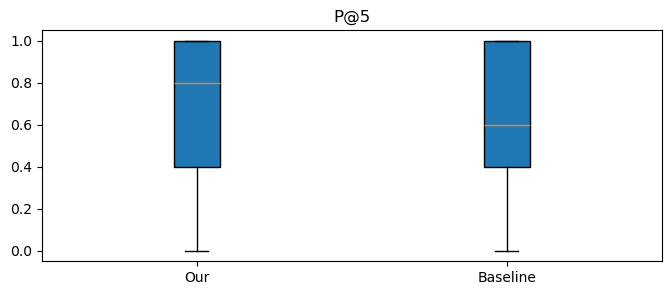

T-test: statistic = 0.46600159913559064, p = 0.6421705206434163


/var/folders/rv/w7k68zds33v40x4d_lx8k5rh0000gn/T/ipykernel_29716/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


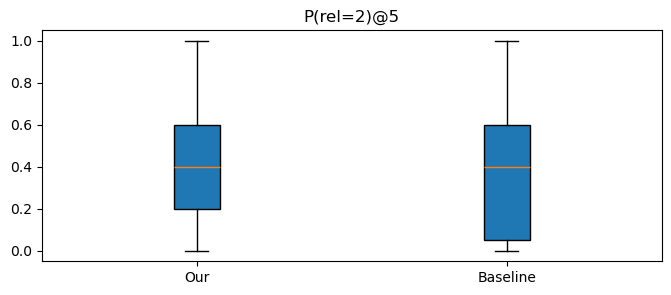

T-test: statistic = 0.22222316916721552, p = 0.824567758091467


/var/folders/rv/w7k68zds33v40x4d_lx8k5rh0000gn/T/ipykernel_29716/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


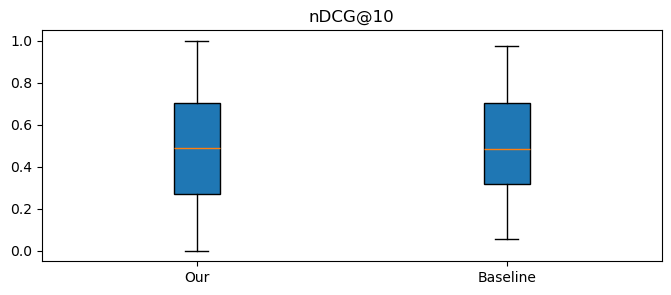

T-test: statistic = 0.09962180522277511, p = 0.9208327476126805


/var/folders/rv/w7k68zds33v40x4d_lx8k5rh0000gn/T/ipykernel_29716/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


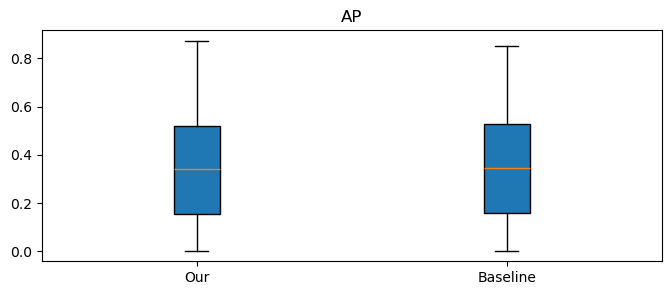

T-test: statistic = 0.21293222072382068, p = 0.831788800965761


/var/folders/rv/w7k68zds33v40x4d_lx8k5rh0000gn/T/ipykernel_29716/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


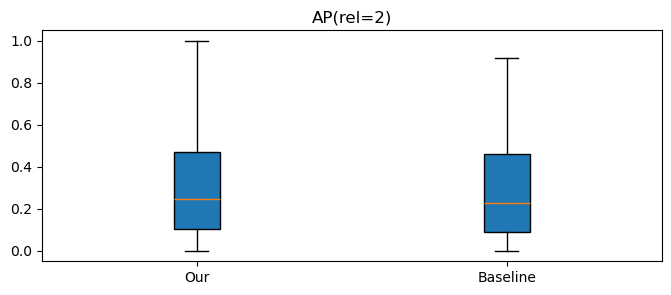

In [24]:
# Prepare data for comparison between "our" method and the baseline
data = [
    (OurPat5, BaselinePat5),          # Precision at 5 (P@5)
    (OurPRel2at5, BaselinePRel2at5),  # Precision for relevance 2 at 5 (P(rel=2)@5)
    (OurnDCGat10, BaselinenDCGat10),  # Normalized Discounted Cumulative Gain at 10 (nDCG@10)
    (OurAP, BaselineAP),              # Average Precision (AP)
    (OurAPRel2, BaselineAPRel2)       # Average Precision for relevance 2 (AP(rel=2))
]

# List of metric names for labeling the boxplots
metrics = ["P@5", "P(rel=2)@5", "nDCG@10", "AP", "AP(rel=2)"]

# Generate boxplots and t-test results for each metric
boxplot_and_results(data, metrics)

### Query Performance Analysis

The analysis of query processing times reveals the following insights:

1. **Average Query Processing Time:** The system achieved an average processing time of **616.937 ms** for the 200 queries analyzed.
2. **Distribution of Times:** The box plot illustrates the spread of query processing times, showing a concentration of values around the median, with some notable outliers exceeding 2000 ms.
3. **Processing Rate:** Queries were executed at a rate of approximately **1.36 queries per second**.

These results indicate a generally consistent performance, with a small subset of queries taking significantly longer to process. The presence of outliers suggests potential cases for further investigation to ensure stable and predictable performance.

In [25]:
@profile
def timed_query_process(query, index, heap_size=10):
    """
    Processes a query and measures the execution time using the @profile decorator.

    Parameters:
        query (str): The input text query to be processed.
        index (InvertedIndex): The inverted index used for retrieving relevant documents.
        heap_size (int): The maximum number of results to return. Defaults to 10.

    Returns:
        list[tuple]: A list of tuples (score, docid), sorted in descending order of score.
    """
    qtokens = set(preprocess(query))        # Tokenize and preprocess the query
    qtermids = index.get_termids(qtokens)   # Map tokens to term IDs
    postings = index.get_postings(qtermids) # Retrieve postings for the term IDs
    return daat(postings, heap_size)        # Execute DAAT and return results

Query Processing: 100%|██████████| 200/200 [02:27<00:00,  1.35it/s]

Mean: 616.937 ms


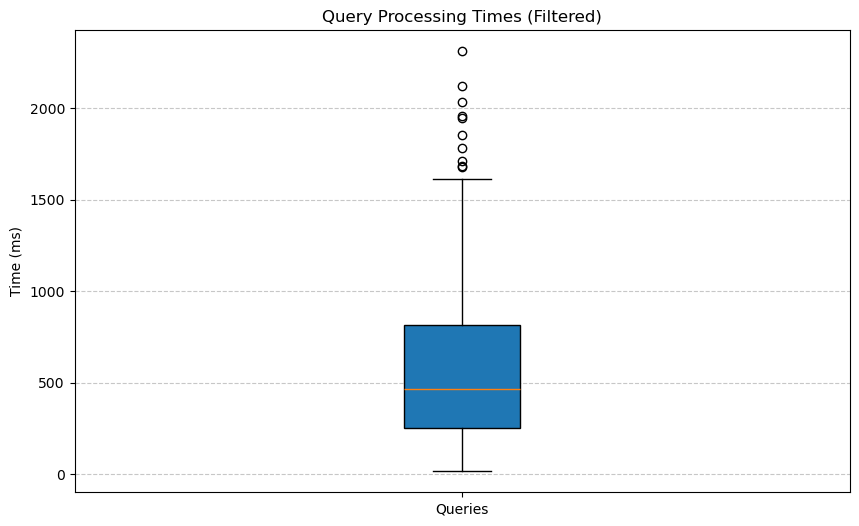

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a dictionary to store query results
query_results = dict()

# Initialize a list to store query processing times (in milliseconds)
timing_results = []

if environment == 'local':
    # Process each query in the "test-2020" topics
    for query in tqdm(
        query_dataset.get_topics("test-2020").itertuples(index=False),
        desc='Query Processing',
        total=len(query_dataset.get_topics("test-2020"))
    ):
        # Process the query using the timed query processing function
        res = timed_query_process(query.query, inv_index)

        # Initialize the result list for the current query
        query_results[query.query] = []

        # Retrieve document details for each result
        for r in res:
            row = dataset.loc[dataset["docno"] == r[1]]
            query_results[query.query].append((row.docno.values, row.text.values))

    # Convert timing results to a NumPy array
    timing_results = np.array(timing_results)
    np.save("Files/timing_results.npy", timing_results)
else:
    # Load the saved timing results from the file
    timing_results = np.load("Files/timing_results.npy")

# Filter out the top 5% and bottom 5% of timing values
filtered_timings = np.sort(timing_results)[
    int(len(timing_results) * 0.05) : int(len(timing_results) * 0.95)
]

# Print the mean processing time of filtered timings
print(f"Mean: {np.mean(filtered_timings):.3f} ms")

# Create a boxplot of the filtered processing times
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_timings, vert=True, patch_artist=True)
plt.title("Query Processing Times (Filtered)")
plt.ylabel("Time (ms)")
plt.xticks([1], ["Queries"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Rocchio

### Function: `daat_with_weights`

This function extends the Document-At-A-Time (DAAT) algorithm by incorporating weighted scores, allowing for relevance feedback through methods such as the **Rocchio algorithm**. It processes weighted posting lists to rank documents based on their adjusted relevance scores.

---

### Arguments
- **`postings` (`dict`)**: A dictionary where:
  - Keys are posting list iterators corresponding to query terms.
  - Values are weights associated with each posting list, reflecting the importance or influence of the terms (e.g., derived from relevance feedback in Rocchio).
- **`k` (`int`, optional)**: The maximum number of top-ranked results to return. Defaults to `10`.

---

### Workflow

1. **Initialize Top-k Queue:**
   - Creates a `TopQueue` object to store the top-k highest-scoring documents during the traversal.

2. **Retrieve Posting Lists:**
   - Extracts all posting list iterators from the `postings` dictionary.
   - Finds the smallest `docid` across all active posting lists using the `min_docid()` function.

3. **Document Scoring:**
   - Iteratively processes documents in ascending order of `docid`.
   - For each `current_docid`:
     - **Score Calculation:**
       - Iterates through all posting lists.
       - If the `current_docid` is present in a posting list, its score is weighted by the term's importance (weight) and added to the total score.
       - Advances the iterator to the next document in the posting list.
     - **Next Document Identification:**
       - Tracks the smallest `docid` to process next.

4. **Insert into Top-k Queue:**
   - After computing the score for `current_docid`, inserts the `(docid, score)` pair into the `TopQueue`.

5. **Return Sorted Results:**
   - The `TopQueue` is sorted in descending order of scores and returned as the final ranked list.

---

### Key Features
1. **Weighted Scoring:**
   - Each term's contribution to a document's score is adjusted by its associated weight. This allows for flexible integration of query expansion techniques like Rocchio, where weights are derived from feedback (e.g., adjusted based on user relevance judgments).

2. **Efficient Traversal:**
   - Processes documents in ascending order of `docid`, minimizing redundant operations and maintaining efficiency.

3. **Dynamic Ranking:**
   - Updates and maintains the top-k results during traversal using a priority queue.

---

### Example Usage
Given the following posting lists:
- **Term 1 (weight=2):**
  - Documents: `doc1 (score=0.8), doc2 (score=0.4)`
- **Term 2 (weight=1):**
  - Documents: `doc2 (score=0.5), doc3 (score=0.9)`

Calling `daat_with_weights(postings, k=2)` would:
1. Compute weighted scores:
   - `doc1: 0.8 * 2 = 1.6`
   - `doc2: (0.4 * 2) + (0.5 * 1) = 1.3`
   - `doc3: 0.9 * 1 = 0.9`
2. Return the top-2 results:
    - `[(1.6, doc1), (1.3, doc2)]`

In [27]:
def daat_with_weights(postings, k=10):
    """
    Implements the Document-At-A-Time (DAAT) algorithm with weighted term contributions.

    Parameters:
        postings (dict[PostingListIterator, float]): A dictionary where keys are posting list iterators 
                                                     and values are weights representing term importance.
        k (int): Maximum number of results to return. Defaults to 10.

    Returns:
        list[tuple]: A list of tuples (score, docid), sorted in descending order of score.
    """
    top = TopQueue(k)  # Priority queue to store the top-k results
    posting_lists = postings.keys()
    current_docid = min_docid(posting_lists)  # Initialize with the smallest docid across all posting lists
    
    while current_docid != math.inf:
        score = 0
        next_docid = math.inf

        # Compute weighted scores for the current document and find the next docid
        for posting, weight in postings.items():
            if posting.docid() == current_docid:
                score += posting.score() * weight  # Apply weight to the term's contribution
                posting.next()
            if not posting.is_end_list():
                next_docid = min(posting.docid(), next_docid)

        # Insert the current document and its weighted score into the top-k queue
        top.insert(current_docid, score)

        # Update to the next document ID to process
        current_docid = next_docid

    # Return the top-k results sorted by score in descending order
    return sorted(top.queue, reverse=True)

### Function: `rocchio_pseudo_feedback`

This function implements the Rocchio algorithm for pseudo-relevance feedback in information retrieval. The goal is to improve the initial query by adjusting its term weights based on the terms found in a set of documents deemed relevant. The implementation focuses on optimizing query terms and returns a new query vector with adjusted weights.

---

### Key Features

1. **Query Refinement:**
   - Adjusts the original query vector using terms from documents considered relevant.
   - Relies on **pseudo-relevance feedback**, assuming a predefined set of documents as relevant (e.g., top-k results from an initial search).

2. **Weighted Query Expansion:**
   - Assigns weights to terms in the query and relevant documents using Rocchio parameters:
     - $\alpha$: Weight of the original query terms.
     - $\beta$: Weight of the terms extracted from relevant documents.

3. **Optimization for Top Terms:**
   - After applying Rocchio, the algorithm can restrict the query to only the top-10 terms with the highest weights, improving focus and precision.

---

### Arguments

- **`query_terms` (`list`):**
  - The terms of the original query.
  - These terms will form the basis of the initial query vector.

- **`doc_ids` (`list`):**
  - A list of document IDs considered relevant.
  - These documents contribute to the new query vector through their term frequencies.

- **`lexicon` (`dict`):**
  - A dictionary mapping terms to their metadata:
    - Key: The term (string).
    - Value: A tuple containing the term ID and statistics (e.g., document frequency).
  - Used to translate terms into term IDs for efficient operations.

- **`direct_index` (`dict`):**
  - A dictionary mapping document IDs to their term frequencies:
    - Key: Document ID.
    - Value: A dictionary where keys are term IDs and values are their term frequencies in the document.

---

### Workflow

1. **Parameter Initialization:**
   - $\alpha = 8$: Emphasizes the original query terms.
   - $\beta = 16$: Amplifies the terms from the relevant documents.
   - These weights balance the influence of the original query and the feedback.

2. **Create the Query Vector:**
   - Iterates through the `query_terms`, assigning a unit weight ($1$) to each term found in the `lexicon`.
   - Unknown terms are ignored (weight $0$).

3. **Construct the Relevant Vector:**
   - For each relevant document in `doc_ids`, terms and their frequencies are aggregated across all documents.
   - The resulting `relevant_vector` represents the sum of term frequencies for all relevant documents.

4. **Combine Vectors:**
   - Constructs a new query vector by combining:
     - The original query vector, weighted by $ \alpha $.
     - The normalized relevant vector, weighted by $ \beta $ and divided by the number of relevant documents.
   - Formula:
     $$
     Q = \alpha \cdot Q_0 + \beta \cdot \left( \frac{1}{|D_R|} \sum_{d \in D_R} V(d) \right)
     $$
     - $ Q_0 $: Original query vector.
     - $ D_R $: Set of pseudo-relevant documents.
     - $ V(d) $: Vector of terms in document $ d $.
     - $ \alpha, \beta $: Hyperparameters adjusting weight contributions of query and document vectors.
   - The weights for each term are stored as a floating-point value in `new_query_vector`.

5. **Translate Term IDs Back to Strings:**
   - The inverse lexicon (`inv_lexicon`) is used to convert term IDs back to their original string representation for the final query vector.

---

### Return Value

- **`new_query_vector` (`dict`):**
  - A dictionary where:
    - Key: Term (string).
    - Value: Adjusted weight (float) for the term.
  - Represents the expanded and weighted query vector after applying Rocchio.

---

### Example Usage

Given the following inputs:
- **Query Terms:** `["information", "retrieval"]`
- **Relevant Document IDs:** `[1, 2, 3]`
- **Lexicon:** `{ "information": (0, stats), "retrieval": (1, stats), ... }`
- **Direct Index:** `{ 1: {0: 3, 2: 1}, 2: {1: 2}, 3: {0: 2, 3: 1} }`

The function:
1. Assigns weights $\alpha$ and $\beta$.
2. Constructs the relevant vector by summing term frequencies across documents 1, 2, and 3.
3. Produces a new query vector combining the original query and the aggregated feedback.

Output:
  ```python
  {
      "information": 8.0,  # Original term boosted by alpha
      "retrieval": 8.0,    # Original term boosted by alpha
      "additional_term": 5.3,  # New term derived from relevant documents
      ...
  }
  ```

### Notes 
-   Simplification: This implementation assumes ( $\gamma$ = 0 ), meaning terms from non-relevant documents are ignored.
-   Pseudo-Relevance Feedback: As this is a pseudo-feedback method, relevance is assumed and not user-provided.

In [28]:
def rocchio_pseudo_feedback(query_terms, doc_ids, lexicon, direct_index):
    """
    Implements the Rocchio algorithm for pseudo-relevance feedback.

    Parameters:
        query_terms (list[str]): Terms in the original query.
        doc_ids (list[int]): Document IDs considered relevant for pseudo-feedback.
        lexicon (dict): Dictionary mapping terms to metadata [term_id, document frequency, term frequency].
        direct_index (dict): Mapping of document IDs to term IDs and their term frequencies.

    Returns:
        dict: A new query vector where keys are terms (str) and values are their updated weights (float).
    """
    # Create an inverted lexicon to map term IDs back to terms
    inv_lexicon = {v[0]: k for k, v in lexicon.items()}

    # Parameters for Rocchio algorithm
    alpha = 8   # Weight for the original query
    beta = 16   # Weight for the relevant documents

    # Create the original query vector
    query_vector = defaultdict(int)
    for term in set(query_terms):  # Use set for optimization since weights are uniform initially
        if term in lexicon:  # Ignore unknown terms
            query_vector[lexicon[term][0]] = 1  # Map to term IDs with a weight of 1

    # Create the relevant document vector
    relevant_vector = defaultdict(float)
    doc_set = set(doc_ids)  # Convert to set for optimization
    
    for doc in doc_set:
        for term_id, tf in direct_index[doc].items():
            relevant_vector[term_id] += tf  # Accumulate term frequencies across relevant documents

    # Construct the new query vector
    new_query_vector = defaultdict(float)
    for term_id in query_vector.keys() | relevant_vector.keys():  # Iterate over all unique terms
        new_query_vector[inv_lexicon[term_id]] = (
            (alpha * query_vector[term_id]) + 
            (beta * relevant_vector[term_id] / len(doc_ids))
        )

    return new_query_vector

### Function: `query_process_with_rocchio`

This function extends a standard query processing pipeline by incorporating **Rocchio pseudo-relevance feedback**. It refines the query using top-ranked documents from the initial retrieval phase and produces a final ranked list of documents based on adjusted term weights.

---

### Arguments

- **`query` (`str`):** 
  - The raw user query, which will be preprocessed and expanded using Rocchio.

- **`index` (`InvertedIndex`):** 
  - The inverted index containing the necessary data structures for term lookups, posting lists, and document statistics.

- **`heap_size` (`int`, optional):** 
  - The maximum number of top-ranked documents to return. Defaults to `10`.

- **`max_rel_docs` (`int`, optional):** 
  - The number of top documents from the initial search to consider as relevant for Rocchio feedback. Defaults to `5`.

---

### Workflow

1. **Preprocessing and Initial Search:**
   - The query is preprocessed using the `preprocess()` function to normalize and tokenize it.
   - Term IDs for the query terms are retrieved using the index's `get_termids()` method.
   - Posting lists for the query terms are fetched using `get_postings()`.
   - The initial document retrieval is performed using the `daat()` function, retrieving the top `max_rel_docs` documents based on their scores.

2. **Extract Relevant Documents:**
   - From the initial retrieval results, the document IDs of the top-ranked documents are extracted and treated as "relevant."

3. **Rocchio Feedback:**
   - The `rocchio_pseudo_feedback()` function is used to refine the query based on:
     - The original query terms.
     - Terms from the top `max_rel_docs` relevant documents.
   - The function outputs a new query vector with adjusted term weights.

4. **Weighted Query Processing:**
   - The refined query terms are mapped back to term IDs using the index's `get_termids()` method.
   - Posting lists for the refined query terms are retrieved using `get_postings()`.
   - Each posting list is paired with its corresponding term weight from the new query vector, forming a dictionary of weighted postings.

5. **Top Terms Restriction:**
   - The weighted postings dictionary is sorted by term weights in descending order.
   - Only the top 10 terms with the highest weights are retained to focus the query on the most significant terms.

6. **Final Retrieval:**
   - The `daat_with_weights()` function is used to process the weighted postings and retrieve the top `heap_size` ranked documents.

---

### Return Value

- **`list`:** 
  - A list of tuples `(score, docid)`, sorted in descending order by score, representing the top-ranked documents after Rocchio feedback.

---

### Key Features

1. **Pseudo-Relevance Feedback:**
   - Improves the query by incorporating terms from the top-ranked documents of the initial retrieval phase.

2. **Weighted Query Processing:**
   - Dynamically adjusts the impact of query terms based on their relevance, as determined by the Rocchio algorithm.

3. **Term Filtering:**
   - Limits the refined query to the top 10 terms with the highest weights, ensuring the query remains focused and computationally efficient.

4. **Final Scoring:**
   - Uses weighted document scores in the `daat_with_weights()` function for the final ranking.

---

### Example Workflow

#### Inputs:
- **Query:** `"information retrieval"`
- **Index:** An inverted index containing document statistics and posting lists.
- **Heap Size:** `10`
- **Max Relevant Docs:** `5`

#### Process:
1. **Initial Retrieval:**
   - Retrieve top 5 relevant documents for the query `"information retrieval"`.
   - Example: `[(0.85, "doc1"), (0.78, "doc2"), ...]`

2. **Rocchio Feedback:**
   - Refine the query using terms from the top 5 documents.
   - Example: Add terms like `"system"`, `"retrieval"`, `"information"` with updated weights.

3. **Weighted Processing:**
   - Apply weights to the terms and retrieve a new top-ranked list of documents.
   - Example: `[(1.15, "doc1"), (0.98, "doc3"), ...]`

#### Output:
- A ranked list of documents after query refinement:
  ```python
  [(1.15, "doc1"), (0.98, "doc3"), (0.85, "doc2"), ...]
  ```

In [29]:
def query_process_with_rocchio(query, index, heap_size=10, max_rel_docs=5):
    """
    Processes a query using the Rocchio algorithm for pseudo-relevance feedback.

    Parameters:
        query (str): The original text query.
        index (InvertedIndex): The inverted index used for document retrieval.
        heap_size (int): The maximum number of results to return. Defaults to 10.
        max_rel_docs (int): The maximum number of relevant documents to consider for feedback. Defaults to 5.

    Returns:
        list[tuple]: A list of tuples (score, docid), sorted in descending order of score.
    """
    # Preprocess the query and map tokens to term IDs
    qtokens = set(preprocess(query))
    qtermids = index.get_termids(qtokens)
    
    # Retrieve postings and execute DAAT for the initial query
    postings = index.get_postings(qtermids)
    res = daat(postings, max_rel_docs)
    
    # Extract relevant document IDs
    relevant_docids = [r[1] for r in res]
    
    # Apply Rocchio pseudo-feedback to generate a new query vector
    new_query_terms = rocchio_pseudo_feedback(qtokens, relevant_docids, index.lexicon, index.direct)
    
    # Map the new query terms to term IDs and retrieve postings
    qtermids = index.get_termids(new_query_terms.keys())
    postings = index.get_postings(qtermids)
    
    # Assign weights to postings based on the Rocchio query vector
    weighted_postings = {}
    for term_weight, posting in zip(new_query_terms.values(), postings):
        weighted_postings[posting] = term_weight
    
    # Select the top 10 terms based on weight
    top_terms = dict(sorted(weighted_postings.items(), key=lambda item: item[1], reverse=True)[:10])
    
    # Execute DAAT with weights for the refined query
    return daat_with_weights(top_terms, heap_size)

In [30]:
def create_run_file_with_rocchio(topics, inv_index, file_name, max_rel_docs=5):
    """
    Creates a TREC run file using the Rocchio algorithm for pseudo-relevance feedback.

    Parameters:
        topics (DataFrame): DataFrame containing queries with columns 'query' and 'qid'.
        inv_index (InvertedIndex): The inverted index used for retrieving documents.
        file_name (str): Name of the output file where the run data will be saved.
        max_rel_docs (int): Maximum number of relevant documents to consider for feedback. Defaults to 5.

    Returns:
        None: Writes the results to the specified file in TREC run format.
    """
    print(f"Creating run file with Rocchio using {max_rel_docs} relevant documents...")
    
    k = 1000  # Maximum number of results to retrieve for each query
    results = []

    for query in tqdm(topics.itertuples(index=False), desc='Creating run file', total=len(topics)):
        # Process the query with Rocchio feedback
        res, query_id = query_process_with_rocchio(query.query, inv_index, k, max_rel_docs), query.qid
        
        # Format the results in TREC run file format
        results.extend([
            f"{query_id} Q0 {r[1]} {rank} {r[0]} run.txt\n" 
            for rank, r in enumerate(res, start=1)
        ])

    # Write the results to the specified file
    with open(file_name, "w") as f:
        f.writelines(results)

### Grid Search for Rocchio Parameters

| max_rel_docs | nDCG@10       | P@5              | AP               | AP(rel=2)        | P(rel=2)@5      | T-test p-value (nDCG@10) |
|--------------|---------------|------------------|------------------|------------------|-----------------|--------------------------|
| 1            | 0.5245009498  | 0.6666666667     | 0.3817195994     | 0.3247597296     | 0.4666666667    | 0.5728568238             |
| 2            | 0.5161782473  | 0.6888888889     | 0.3897787176     | 0.3316704266     | 0.4666666667    | 0.6792292506             |
| 3            | 0.5231853167  | 0.6740740741     | 0.3879579208     | 0.3280425272     | 0.4555555556    | 0.5827778436             |
| 4            | 0.5086964628  | 0.6814814815     | 0.3917376645     | 0.3229090763     | 0.4481481481    | 0.7800553773             |
| 5            | 0.5075918559  | 0.6703703704     | 0.3942849395     | 0.3163657341     | 0.4407407407    | 0.7997302094             |
| 6            | 0.4873808658  | 0.6407407407     | 0.3892269209     | 0.3112125457     | 0.4259259259    | 0.9115989294             |
| 7            | 0.4734795397  | 0.6222222223     | 0.3766581976     | 0.3046578652     | 0.4185185185    | 0.7188811973             |
| 8            | 0.4804070811  | 0.6259259259     | 0.3797445758     | 0.3062075768     | 0.4222222222    | 0.8172812243             |
| 9            | 0.4767214167  | 0.6148148148     | 0.3793320168     | 0.3067780814     | 0.4074074074    | 0.7660457428             |
| 10           | 0.4608116148  | 0.6074074074     | 0.3737128892     | 0.3003469571     | 0.4037037037    | 0.5654268582             |

The evaluation of the Rocchio-enhanced system, across varying values of  max\_rel\_docs , does not show meaningful improvements in performance metrics compared to the baseline system. Statistical analysis further indicates that the differences between the Rocchio-enhanced results and the baseline are not statistically significant. This lack of statistical independence undermines the potential impact of Rocchio in this context.

Given these results, introducing Rocchio pseudo-relevance feedback, as implemented here with the current parameter configuration, does not provide sufficient justification for its adoption. Future work could explore alternative configurations or enhanced implementations to assess whether the technique can offer tangible benefits.

Creating run file with Rocchio using 1 relevant documents...


Creating run file: 100% 200/200 [32:09<00:00,  9.65s/it]


{P@5: 0.6666666666666664, P(rel=2)@5: 0.4666666666666667, AP(rel=2): 0.32475972961557925, nDCG@10: 0.5245009498232592, AP: 0.3817195994358212}
T-test: statistic = 0.6188537743506686, p = 0.537340386019781


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


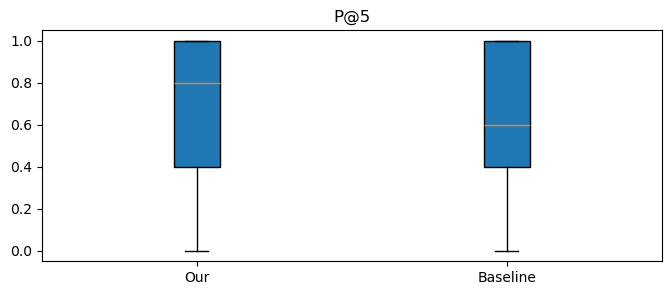

T-test: statistic = 1.0975178606954241, p = 0.2749019842766041


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


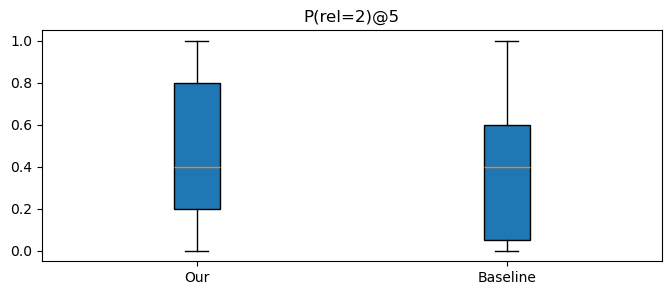

T-test: statistic = 0.565606216556213, p = 0.5728568237996394


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


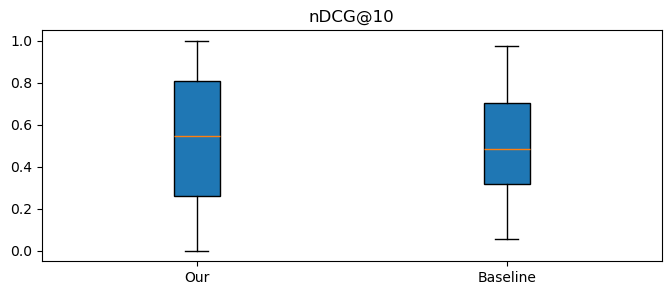

T-test: statistic = 0.45228096049701727, p = 0.6519908148667777


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


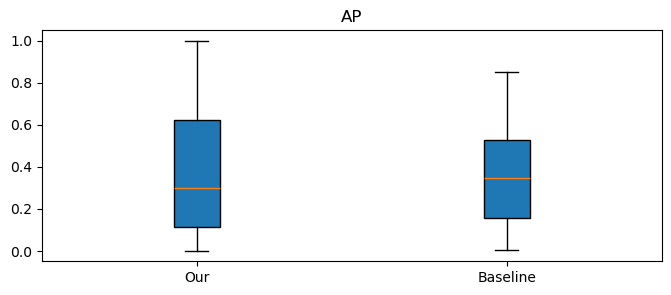

T-test: statistic = 0.5991248282114847, p = 0.5503679877021583


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


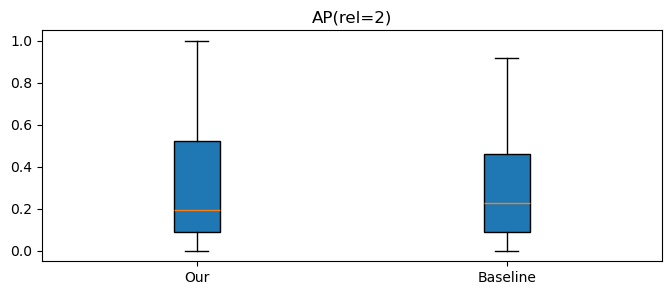

Creating run file with Rocchio using 2 relevant documents...


Creating run file: 100% 200/200 [32:50<00:00,  9.85s/it]


{P@5: 0.688888888888889, P(rel=2)@5: 0.46666666666666656, AP(rel=2): 0.3316704266385286, nDCG@10: 0.5161782473142245, AP: 0.3897787176289288}
T-test: statistic = 0.9700624065900324, p = 0.33422368609341335


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


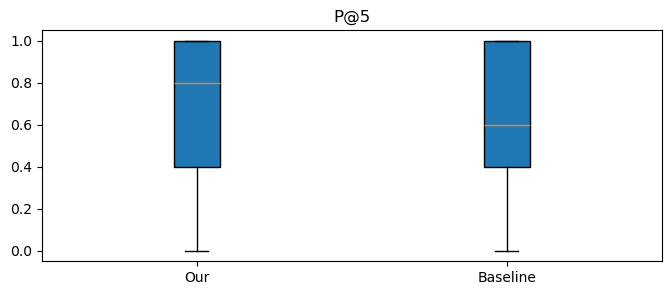

T-test: statistic = 1.1112405433570072, p = 0.26897902052642175


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


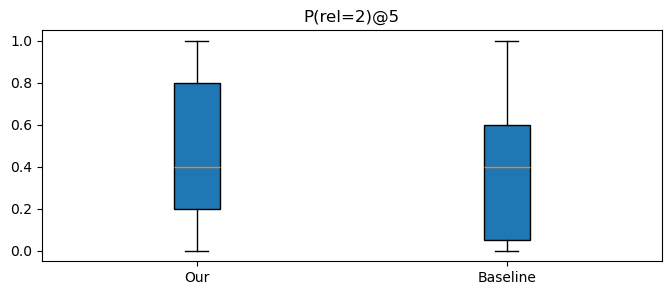

T-test: statistic = 0.4146593972877447, p = 0.6792292506387644


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


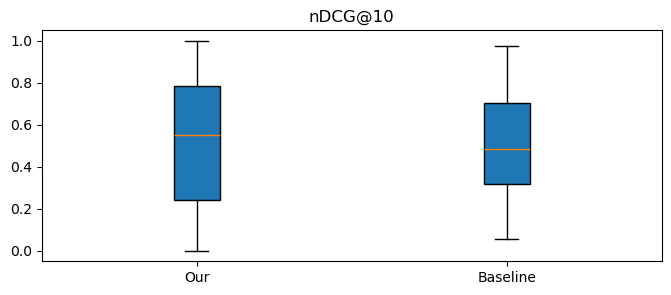

T-test: statistic = 0.645098789539681, p = 0.5202569885836508


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


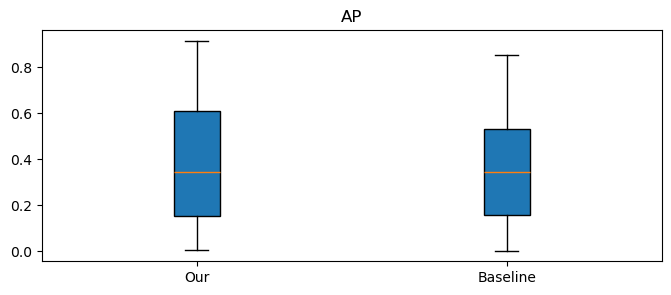

T-test: statistic = 0.7633315686546761, p = 0.44696126093192445


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


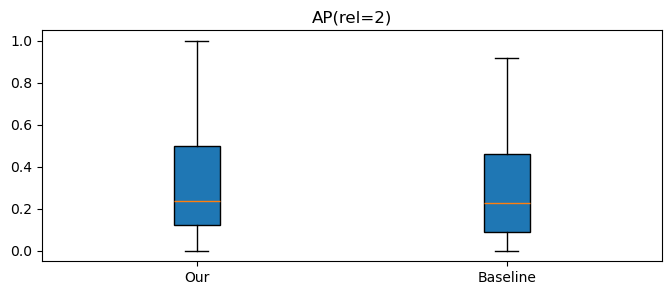

Creating run file with Rocchio using 3 relevant documents...


Creating run file: 100% 200/200 [32:50<00:00,  9.85s/it]


{P@5: 0.674074074074074, P(rel=2)@5: 0.4555555555555555, AP(rel=2): 0.3280425272361269, nDCG@10: 0.5231853166170684, AP: 0.38795792078697855}
T-test: statistic = 0.7260161113006127, p = 0.46942891952042465


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


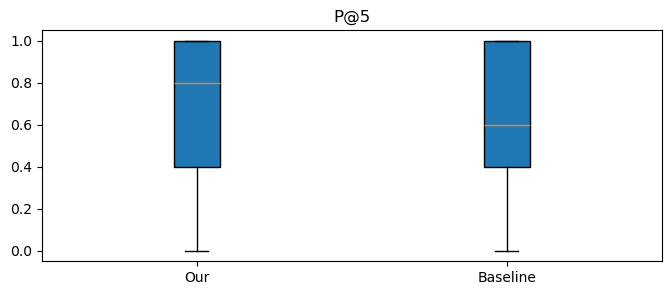

T-test: statistic = 0.9615926521217564, p = 0.33844269226503576


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


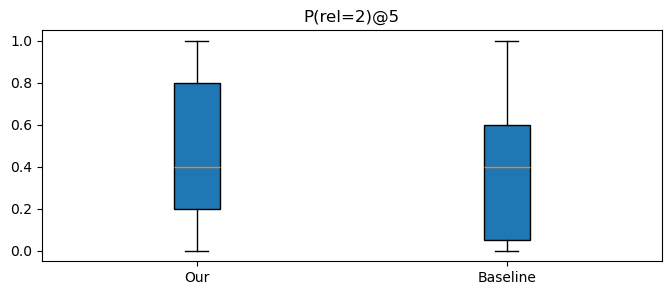

T-test: statistic = 0.5510224573429929, p = 0.5827778436369339


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


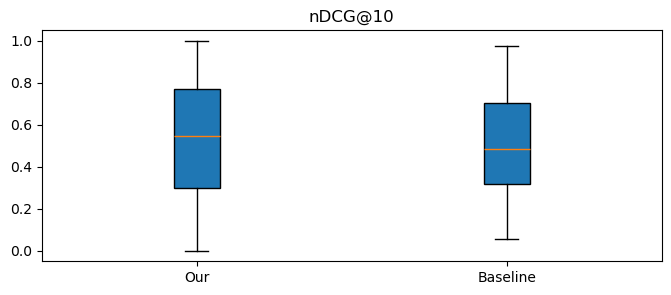

T-test: statistic = 0.6053397251090499, p = 0.546247143156649


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


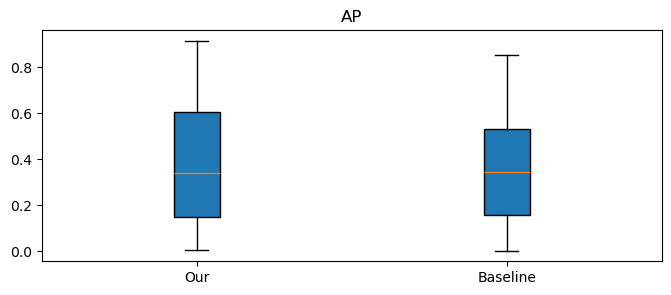

T-test: statistic = 0.6960066276811309, p = 0.48794794800359154


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


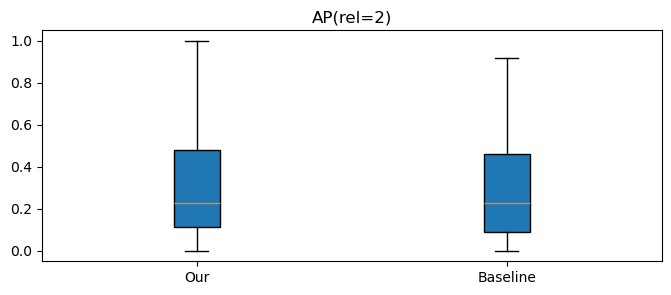

Creating run file with Rocchio using 4 relevant documents...


Creating run file: 100% 200/200 [32:44<00:00,  9.82s/it]


{P@5: 0.6814814814814812, P(rel=2)@5: 0.44814814814814813, AP(rel=2): 0.32290907625596726, nDCG@10: 0.5086964627523187, AP: 0.39173766454767683}
T-test: statistic = 0.8216225929545308, p = 0.4131359142810357


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


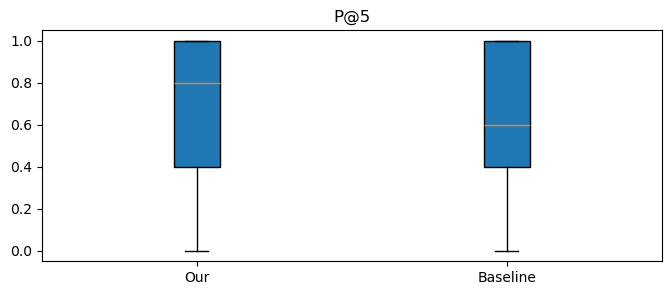

T-test: statistic = 0.8362358802566457, p = 0.4049033713196898


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


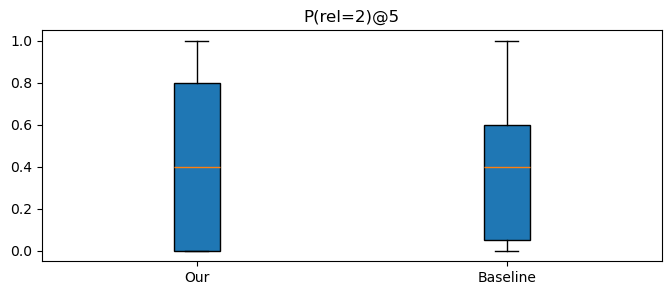

T-test: statistic = 0.2799579262842631, p = 0.7800553773231551


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


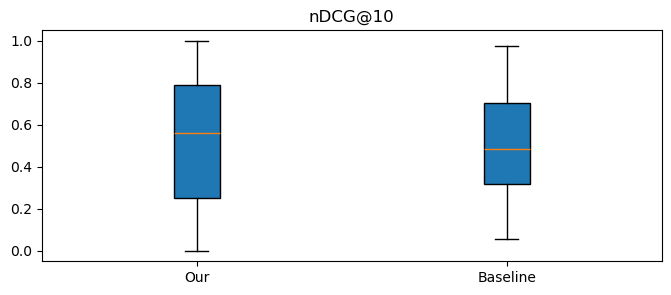

T-test: statistic = 0.677956448433188, p = 0.4992765364906535


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


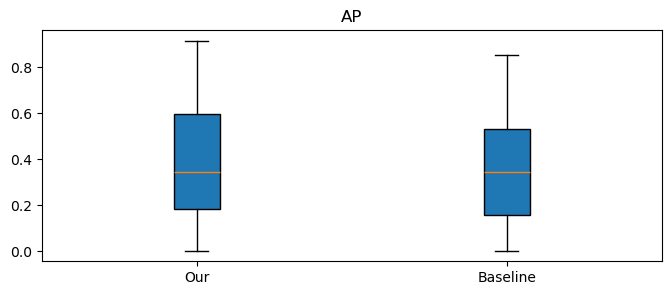

T-test: statistic = 0.5847749800343504, p = 0.5599416948083791


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


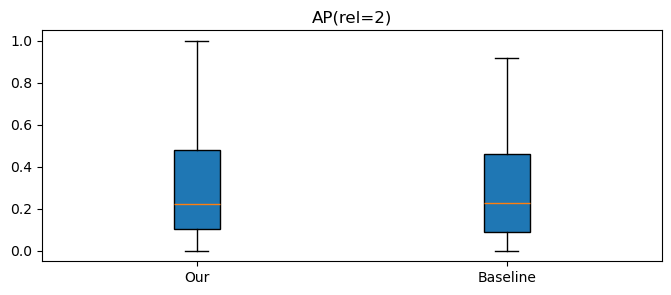

Creating run file with Rocchio using 5 relevant documents...


Creating run file: 100% 200/200 [33:39<00:00, 10.10s/it]


{P@5: 0.6703703703703703, P(rel=2)@5: 0.44074074074074077, AP(rel=2): 0.3163657341115114, nDCG@10: 0.5075918559077727, AP: 0.39428493953112564}
T-test: statistic = 0.6481708950523751, p = 0.5182760165945047


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


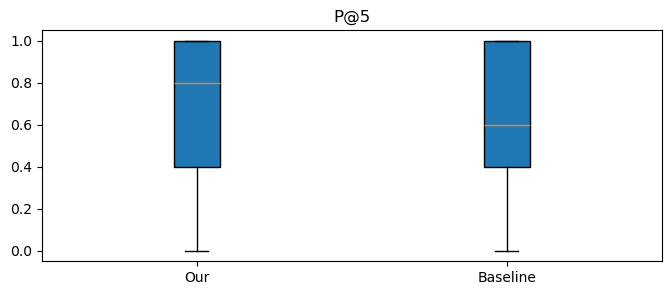

T-test: statistic = 0.7103859156764776, p = 0.4790248775980551


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


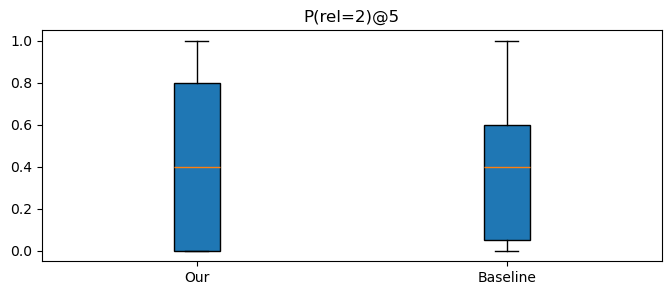

T-test: statistic = 0.25433407388890206, p = 0.7997302094427373


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


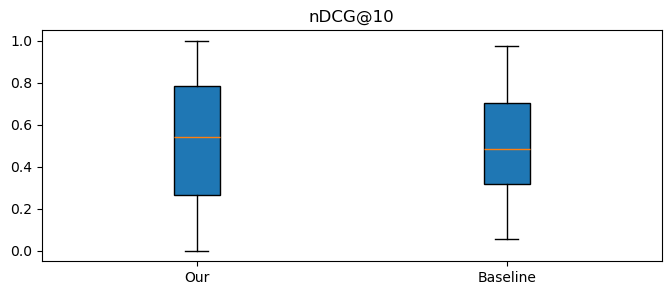

T-test: statistic = 0.7264303489536225, p = 0.46917607816741047


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


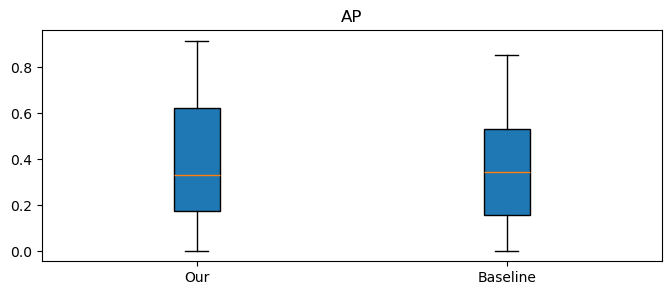

T-test: statistic = 0.4562166731235082, p = 0.6491675370039889


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


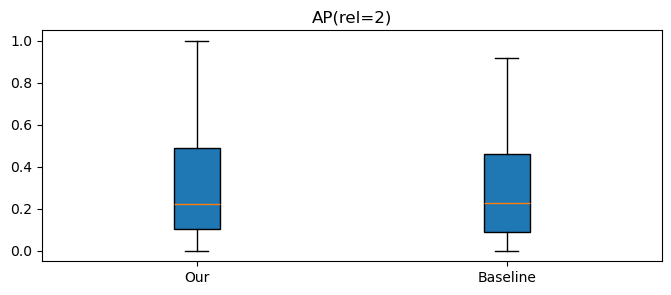

Creating run file with Rocchio using 6 relevant documents...


Creating run file: 100% 200/200 [33:39<00:00, 10.10s/it]


{P@5: 0.6407407407407407, P(rel=2)@5: 0.425925925925926, AP(rel=2): 0.31121254571649143, nDCG@10: 0.48738086575546746, AP: 0.389226920949849}
T-test: statistic = 0.21464373521094024, p = 0.8304574882643607


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


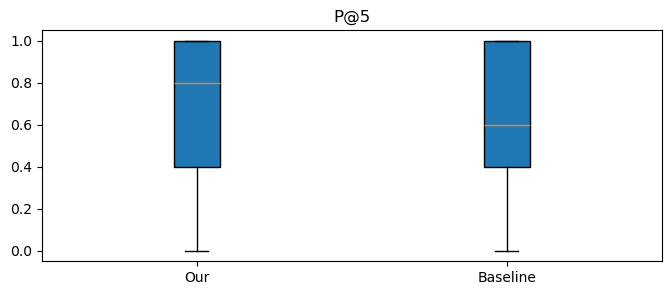

T-test: statistic = 0.4893306401921586, p = 0.6256186896286331


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


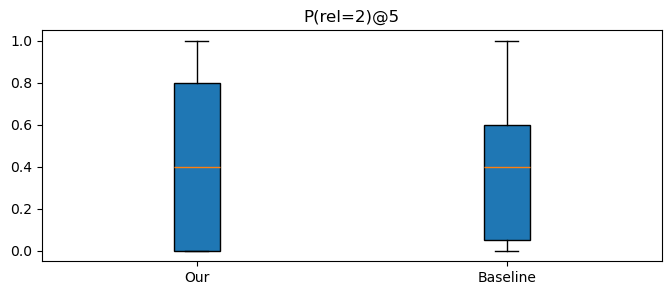

T-test: statistic = -0.11128736156628095, p = 0.9115989294135598


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


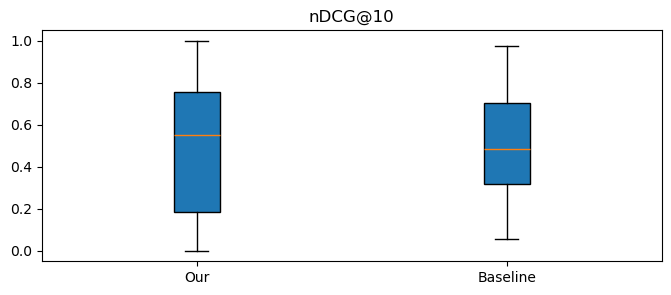

T-test: statistic = 0.6181470102178531, p = 0.5378043555660019


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


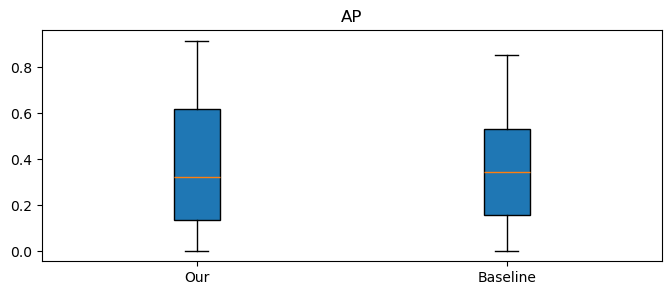

T-test: statistic = 0.35350292707440856, p = 0.7244135343513494


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


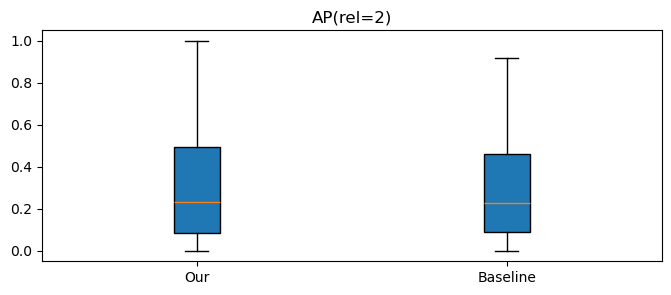

Creating run file with Rocchio using 7 relevant documents...


Creating run file: 100% 200/200 [34:54<00:00, 10.47s/it]


{P@5: 0.6222222222222223, P(rel=2)@5: 0.41851851851851857, AP(rel=2): 0.3046578652030675, nDCG@10: 0.47347953972632445, AP: 0.3766581975991573}
T-test: statistic = -0.052998489564570095, p = 0.9578328642979381


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


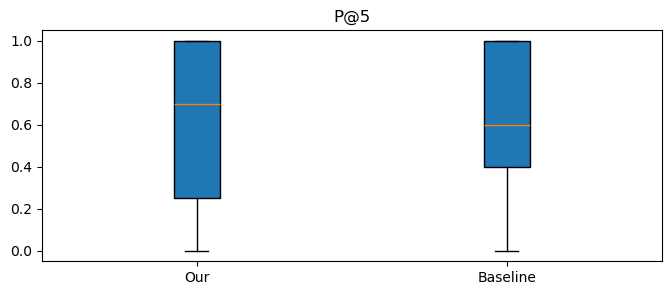

T-test: statistic = 0.3803360216088673, p = 0.7044570675167469


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


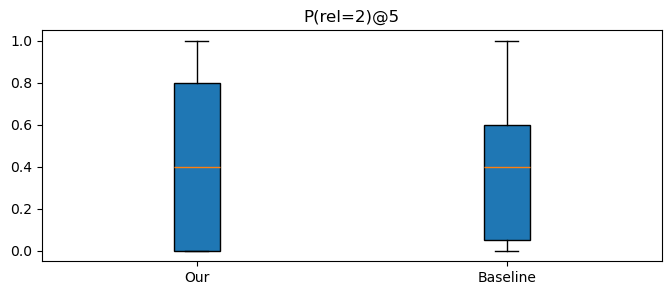

T-test: statistic = -0.3609151059202495, p = 0.718881197326671


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


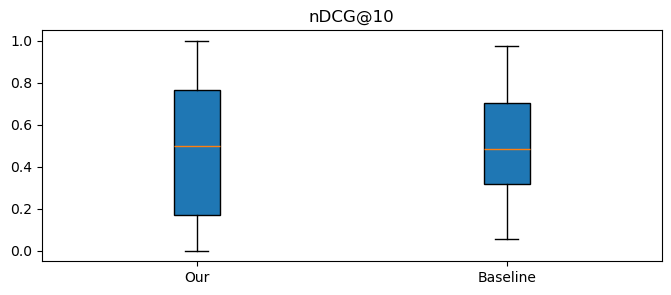

T-test: statistic = 0.3608881280248791, p = 0.7189013063575886


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


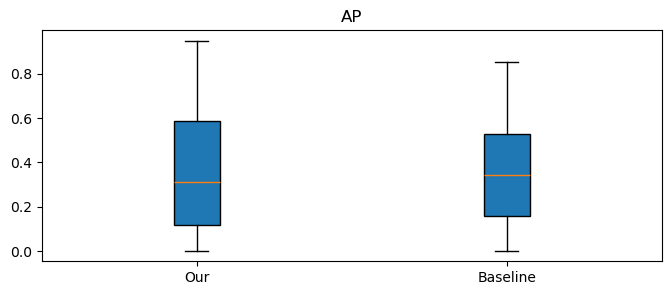

T-test: statistic = 0.22674096307193506, p = 0.8210618645397101


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


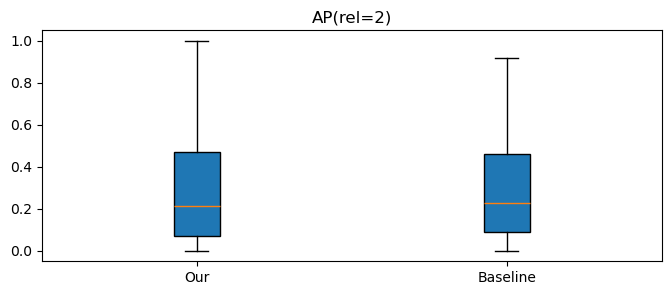

Creating run file with Rocchio using 8 relevant documents...


Creating run file: 100% 200/200 [34:27<00:00, 10.34s/it]


{P@5: 0.625925925925926, P(rel=2)@5: 0.4222222222222222, AP(rel=2): 0.30620757684986954, nDCG@10: 0.4804070810882487, AP: 0.379744575809303}
T-test: statistic = 0.0, p = 1.0


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


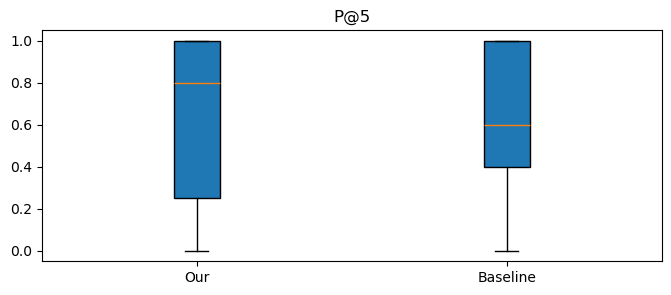

T-test: statistic = 0.4265386348704156, p = 0.6705804065284847


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


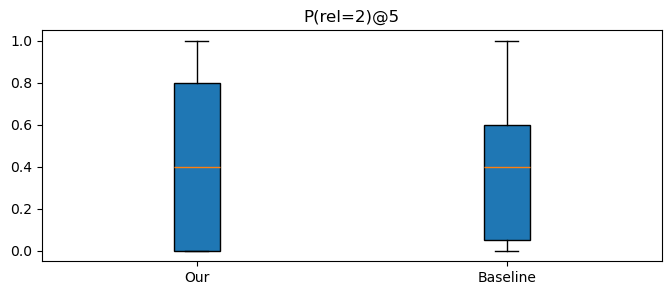

T-test: statistic = -0.23161804431022798, p = 0.8172812242965605


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


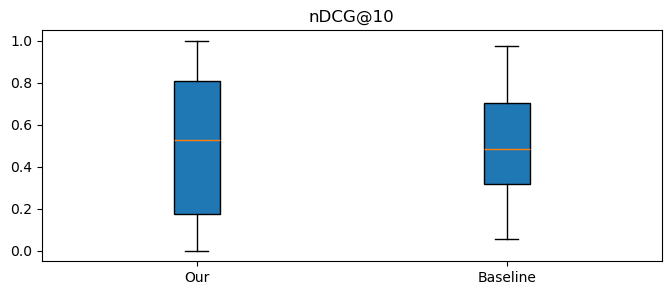

T-test: statistic = 0.4193691627854545, p = 0.6757950344302208


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


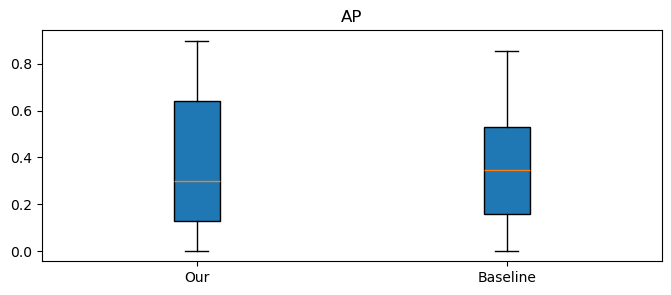

T-test: statistic = 0.25528258614201865, p = 0.7989995225848987


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


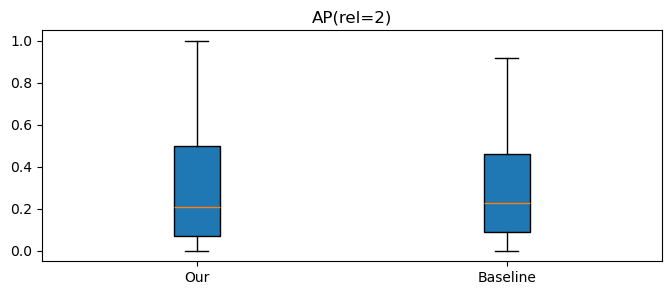

Creating run file with Rocchio using 9 relevant documents...


Creating run file: 100% 200/200 [35:10<00:00, 10.55s/it]


{P@5: 0.6148148148148148, P(rel=2)@5: 0.4074074074074075, AP(rel=2): 0.30677808143740176, nDCG@10: 0.4767214166615894, AP: 0.3793320168250619}
T-test: statistic = -0.15756566914352066, p = 0.8750988136330947


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


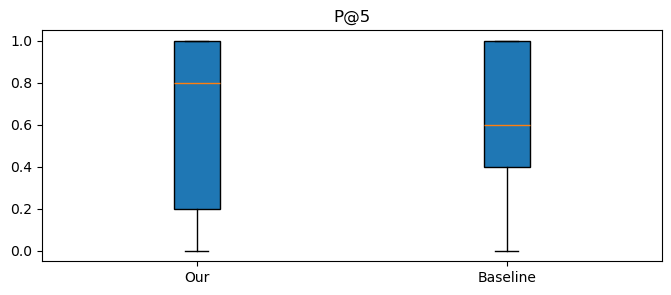

T-test: statistic = 0.2143295626602165, p = 0.8307018325703639


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


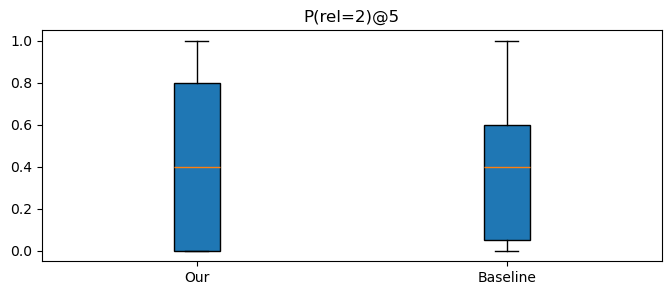

T-test: statistic = -0.2983163013199494, p = 0.7660457427885332


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


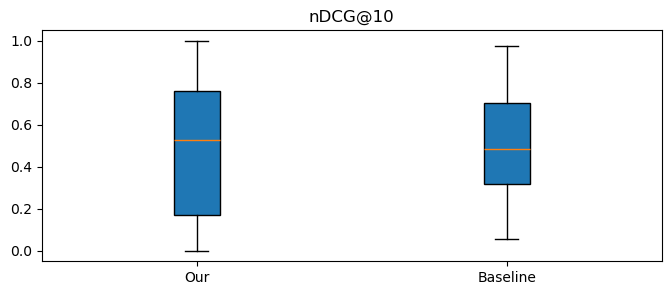

T-test: statistic = 0.4153197058227688, p = 0.6787473647178706


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


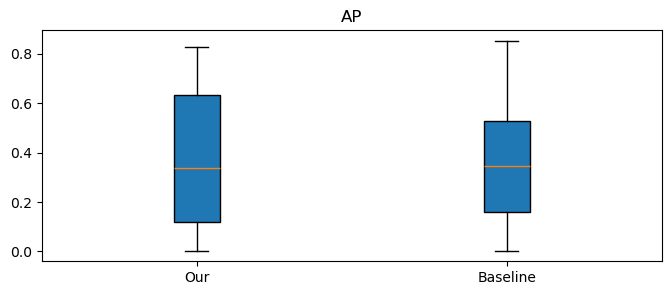

T-test: statistic = 0.26831048644449335, p = 0.7889817981203986


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


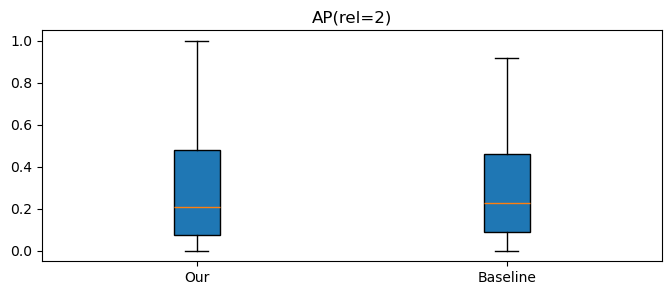

Creating run file with Rocchio using 10 relevant documents...


Creating run file: 100% 200/200 [35:07<00:00, 10.54s/it]


{P@5: 0.6074074074074074, P(rel=2)@5: 0.4037037037037037, AP(rel=2): 0.30034695706714437, nDCG@10: 0.4608116147635149, AP: 0.37371288922146206}
T-test: statistic = -0.2670669511924451, p = 0.7899365097453646


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


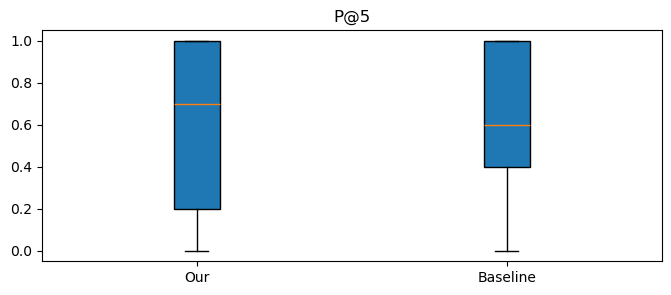

T-test: statistic = 0.16192243634417913, p = 0.8716751821349034


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


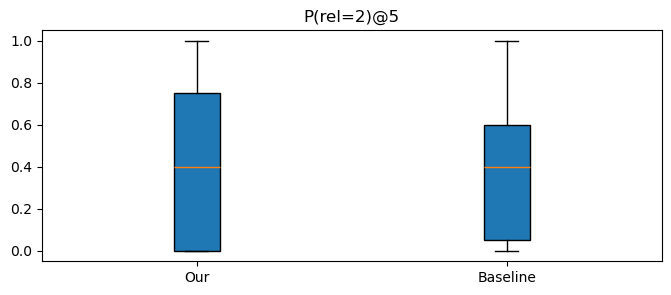

T-test: statistic = -0.5766078282851469, p = 0.565426858222108


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


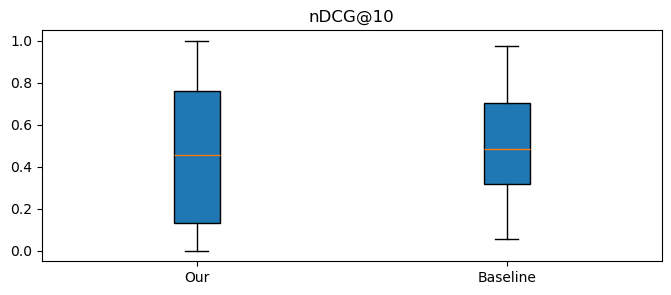

T-test: statistic = 0.30388891634823256, p = 0.7618082407690349


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


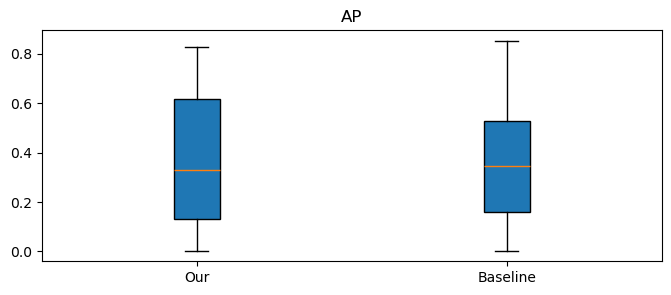

T-test: statistic = 0.14298588178823587, p = 0.8865727824598078


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


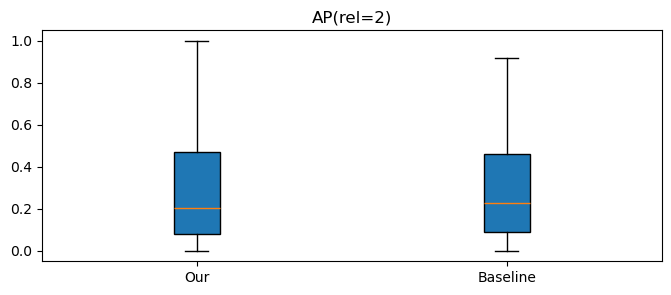

In [55]:
# Evaluate Rocchio feedback with varying numbers of relevant documents
for max_rel_docs in range(1, 11):
    # Perform the TREC test using the Rocchio algorithm with a specified number of relevant documents
    RocchioPat5, RocchioPRel2at5, RocchionDCGat10, RocchioAP, RocchioAPRel2 = trec_test(
        query_dataset.get_topics("test-2020"),          # Retrieve the "test-2020" topics
        inv_index,                                      # Inverted index for document retrieval
        f"Files/run_rocchio_docs_{max_rel_docs}.txt",   # Output file for the current Rocchio run
        create_run_file_with_rocchio,                   # Function to create the run file with Rocchio
        max_rel_docs                                    # Number of relevant documents to consider
    )

    # Prepare data for comparison between Rocchio and baseline performance
    new_data = [
        (RocchioPat5, BaselinePat5),          # Compare Precision at 5 (P@5)
        (RocchioPRel2at5, BaselinePRel2at5),  # Compare Precision for relevance 2 at 5 (P(rel=2)@5)
        (RocchionDCGat10, BaselinenDCGat10),  # Compare Normalized Discounted Cumulative Gain at 10 (nDCG@10)
        (RocchioAP, BaselineAP),              # Compare Average Precision (AP)
        (RocchioAPRel2, BaselineAPRel2)       # Compare Average Precision for relevance 2 (AP(rel=2))
    ]

    # Generate boxplots and perform statistical tests for each metric
    boxplot_and_results(new_data, metrics)


### Query Performance Analysis

The analysis of query processing times reveals the following insights:

1. **Average Query Processing Time:** The system achieved an average processing time of **2716.606 ms** for the 200 queries analyzed.

These results indicate a generally worsening performance compared to the baseline system. The increased query processing times suggest that the Rocchio feedback mechanism introduces excessive additional computational overhead, impacting the overall efficiency of the system, without providing significant improvements in retrieval effectiveness.

In [31]:
@profile
def timed_query_process_with_rocchio(query, index, heap_size=10, max_rel_docs=5):
    """
    Processes a query using the Rocchio algorithm for pseudo-relevance feedback, while measuring execution time.

    Parameters:
        query (str): The original text query to be processed.
        index (InvertedIndex): The inverted index used for document retrieval.
        heap_size (int): The maximum number of results to return. Defaults to 10.
        max_rel_docs (int): The maximum number of relevant documents to consider for feedback. Defaults to 5.

    Returns:
        list[tuple]: A list of tuples (score, docid), sorted in descending order of score.
    """
    qtokens = set(preprocess(query))  # Preprocess the query into tokens
    qtermids = index.get_termids(qtokens)  # Map tokens to term IDs
    postings = index.get_postings(qtermids)  # Retrieve postings for the term IDs
    res = daat(postings, max_rel_docs)  # Execute DAAT to retrieve initial results
    
    relevant_docids = [r[1] for r in res]  # Extract relevant document IDs
    
    # Apply Rocchio pseudo-feedback to refine the query
    new_query_terms = rocchio_pseudo_feedback(qtokens, relevant_docids, index.lexicon, index.direct)
    qtermids = index.get_termids(new_query_terms.keys())  # Map new query terms to term IDs
    postings = index.get_postings(qtermids)  # Retrieve postings for the refined query terms
    
    # Assign weights to postings based on the Rocchio query vector
    weighted_postings = {}
    for term_weight, posting in zip(new_query_terms.values(), postings):
        weighted_postings[posting] = term_weight
    
    # Select the top 10 terms based on weight
    top_terms = dict(sorted(weighted_postings.items(), key=lambda item: item[1], reverse=True)[:10])
    
    # Execute DAAT with weights for the refined query
    return daat_with_weights(top_terms, heap_size)

Mean: 3400.871 ms


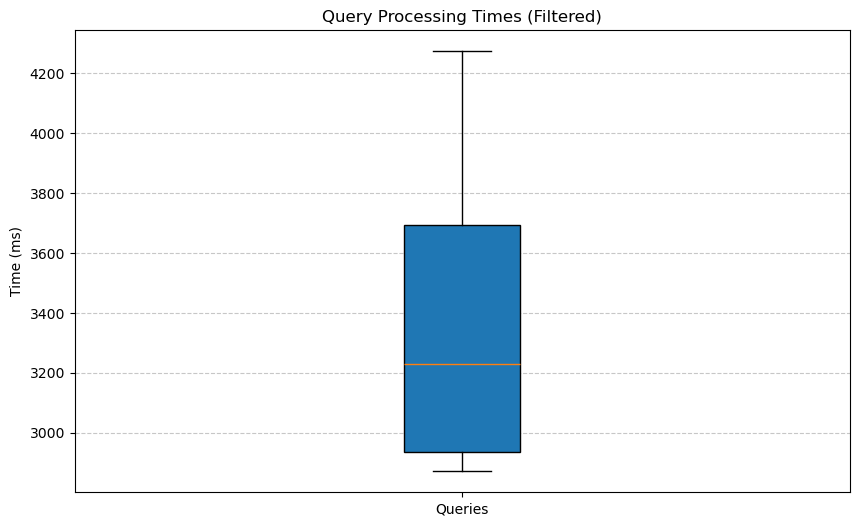

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize dictionaries to store query results and timing results
query_results = dict()
timing_results = []

if environment == 'local':
    # Process a subset of queries (first 5 topics from "test-2020") using Rocchio pseudo-feedback
    for query in query_dataset.get_topics("test-2020")[:5].itertuples(index=False):
        # Process the query with Rocchio feedback and timed execution
        res = timed_query_process_with_rocchio(query.query, inv_index, max_rel_docs=3)
        
        # Store results for the current query
        query_results[query.query] = []
        for r in res:
            # Retrieve document details from the dataset
            row = dataset.loc[dataset["docno"] == r[1]]
            query_results[query.query].append((row.docno.values, row.text.values))

    # Convert timing results to a NumPy array
    timing_results = np.array(timing_results)
    np.save("Files/timing_results_rocchio.npy", timing_results)
else:
    # Load the saved timing results from the file
    timing_results = np.load("Files/timing_results_rocchio.npy")

# Filter out the top 5% and bottom 5% of timing values to remove outliers
filtered_timings = np.sort(timing_results)[
    int(len(timing_results) * 0.05) : int(len(timing_results) * 0.95)
]

# Print the mean processing time for the filtered timings
print(f"Mean: {np.mean(filtered_timings):.3f} ms")

# Create a boxplot of the filtered processing times
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_timings, vert=True, patch_artist=True)
plt.title("Query Processing Times (Filtered)")
plt.ylabel("Time (ms)")
plt.xticks([1], ["Queries"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# **Neural Information Retrieval**

This section explores the integration of BM25 and neural scores using the **SentenceTransformer** model for neural relevance scoring and various techniques to combine scores. Below, we detail the implementation, experiments, and insights gained during the process.

---

## Code Overview
The main objective of the code is to combine traditional BM25 scores with neural similarity scores for a more effective retrieval ranking. Here’s how the process unfolds:

#### **Step 1: Check for Existing Combined Scores**
If a combined score file (`run_combined_alpha_0.0.txt`) already exists, it is loaded to avoid redundant computations. The BM25 and neural run files are merged into a single DataFrame for further processing.

#### **Step 2: Neural Scoring with SentenceTransformer**
If the combined file does not exist:
- **Model Configuration:** A SentenceTransformer model (`all-MiniLM-L6-v2`) is loaded, with the computational device determined automatically (CPU, GPU, or Apple Silicon).
- **Neural Score Calculation:** For each query-document pair in the BM25 run file:
  - The model generates embeddings for the query and the document.
  - The cosine similarity between the embeddings is calculated as the neural score.
- These scores are then appended to the BM25 run file.

#### **Step 3: Score Normalization**
The BM25 and neural scores are normalized to the range [0, 1] using Min-Max scaling. This ensures comparability and stability during combination.

#### **Step 4: Score Combination**
The BM25 and neural scores are combined using a linear interpolation formula:

$$
\text{combined\_score} = \alpha \cdot \text{bm25\_score} + (1 - \alpha) \cdot \text{neural\_score}
$$

Here, $ \alpha $ determines the relative weight of BM25 and neural scores. A grid search is performed over $ \alpha $ values ranging from 0 to 1 (inclusive), with a step of 0.1.

#### **Step 5: Output Combined Runs**
For each $ \alpha $:
1. Combined scores are calculated for each document.
2. Documents are sorted by query ID and combined score in descending order.
3. Results are saved to a TREC-formatted run file (`run_combined_alpha_{alpha:.1f}.txt`).

---

## Key Experiments

#### **Experiment 1: Modifying Scores for Top $ k $ Documents**
An attempt was made to modify the scores of only the top $ k $ documents in each query's ranking, instead of updating all documents. However, significant improvements required $ k \approx 600 $, indicating that modifying scores for a small subset of documents is insufficient. Hence, updating scores for all documents is necessary for meaningful results.

#### **Experiment 2: Alternative Combination Methods**
To explore other possibilities for combining BM25 and neural scores, the following methods were tested:
- **Logarithmic Combination:** Applies a logarithmic transformation to the combined scores.
- **Geometric Mean:** Uses the geometric mean of BM25 and neural scores.
- **Power Mean (Generalized Mean):** Combines scores with varying levels of emphasis controlled by a power parameter.
- **Harmonic Mean:** A weighted harmonic mean of the scores.
- **Exponential Combination:** Applies exponential transformations to BM25 and neural scores.
- **Max-Min Scaling:** Incorporates the maximum and minimum scores.
- **Quadratic Combination:** Applies quadratic weighting to scores.
- **Sigmoid Normalization:** Uses a sigmoid function for non-linear combination.
- **Product Combination:** Combines scores multiplicatively with a weighted exponent.

None of these alternative methods showed significant improvements over the linear combination approach. This suggests that linear interpolation, with proper normalization, is sufficient to effectively combine BM25 and neural scores.

---

## Results and Statistical Evaluation of Combined Scoring Models

This section presents the results obtained from combining BM25 and neural scores using different values of $ \alpha $. It also evaluates the statistical significance of the best-performing model against the baseline BM25 model.

#### 1. **Performance Summary Across $ \alpha $ Values**
The table below summarizes the key retrieval metrics for $ \alpha $ values ranging from 0.0 to 1.0:

| $ \alpha $ | AP       | P(rel=2)@5 | AP(rel=2) | P@5     | nDCG@10   |
|--------------|----------|-------------|-----------|----------|-----------|
| 0.0          | 0.4407   | 0.5852      | 0.4361    | 0.7889   | 0.6552    |
| 0.1          | 0.4530   | 0.6037      | 0.4423    | 0.8000   | 0.6604    |
| 0.2          | 0.4624   | 0.6148      | 0.4444    | 0.8222   | 0.6613    |
| 0.3          | 0.4684   | 0.5889      | 0.4430    | 0.7926   | **0.6622**|
| 0.4          | 0.4682   | 0.5778      | 0.4345    | 0.7926   | 0.6547    |
| 0.5          | 0.4641   | 0.5704      | 0.4220    | 0.7741   | 0.6359    |
| 0.6          | 0.4505   | 0.5370      | 0.4000    | 0.7407   | 0.6165    |
| 0.7          | 0.4369   | 0.5074      | 0.3785    | 0.7222   | 0.5921    |
| 0.8          | 0.4188   | 0.4889      | 0.3564    | 0.7000   | 0.5707    |
| 0.9          | 0.3944   | 0.4556      | 0.3317    | 0.6778   | 0.5421    |
| 1.0          | 0.3634   | 0.4222      | 0.3034    | 0.6444   | 0.5049    |

#### 2. **Best Performance Selection**
While $ \alpha = 0.3 $ yields the highest **nDCG@10** (0.6622), this **does not imply statistical superiority** over other $ \alpha $ values. Without a formal statistical analysis (e.g., comparing p-values between configurations), the notion of "best performance" is heuristic and not statistically validated.

- **Practical Implication:**
  The selection of $ \alpha = 0.3 $ for further evaluation is based solely on the highest observed metric value. This heuristic choice is then used to verify statistical independence with the baseline BM25 model.

#### 3. **Statistical Independence Testing**
To determine whether the combined scoring model ($ \alpha = 0.3 $) is statistically different from the baseline BM25 model, a T-test was conducted on the **nDCG@10** values of the two models.

- **Test Results:**
  - $ \text{T-statistic} = 3.6080 $
  - $ \text{p-value} = 0.00047 $

- **Interpretation:**
  - The null hypothesis states that there is no significant difference between the two models.
  - Given a significance threshold of $ \alpha = 0.05 $, the p-value of $ 0.00047 $ is far below this threshold, allowing us to reject the null hypothesis.
  - This indicates that the combined scoring model ($ \alpha = 0.3 $) is statistically significantly different from the baseline BM25 model in terms of **nDCG@10**.

#### 4. **Temporal Performance and Architectural Considerations**
The computational overhead of the combined model stems primarily from the neural score calculation, which requires embedding queries and documents on-the-fly. While this proof-of-concept demonstrates effectiveness, the approach is not scalable for real-time applications.

- **Future Directions:**
  - Implementing a **vector database** could store precomputed document embeddings and perform efficient similarity searches.
  - **Approximate Nearest Neighbor (ANN) Search** techniques can further reduce query times while maintaining high retrieval effectiveness.

These improvements are outside the scope of this project but represent crucial steps for deploying such models in production environments.

#### 5. **Conclusion**
The combined scoring model, particularly with $ \alpha = 0.3 $, achieves statistically significant improvements over the baseline BM25 model. However, the selection of $ \alpha $ values is based on observed performance and not statistical validation. For real-world deployment, architectural optimizations are necessary to address the computational bottlenecks of neural scoring.

In [58]:
%pip install -U sentence-transformers tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [59]:
import polars as pl

tsv_file = "collection/collection.tsv"
dataset = pl.read_csv(tsv_file, separator='\t', has_header=False, new_columns=['docno', 'text'], encoding="utf-8").to_pandas()

In [60]:
import pyterrier as pt

query_dataset = pt.datasets.get_dataset("msmarco_passage")
query_dataset.get_topics("test-2020")

,qid,query
0,1030303,who is aziz hashim
1,1037496,who is rep scalise
2,1043135,who killed nicholas ii of russia
3,1045109,who owns barnhart crane
4,1049519,who said no one can make you feel inferior
...,...,...
195,985594,where is kampuchea
196,99005,convert sq meter to sq inch
197,997622,where is the show shameless filmed
198,999466,where is velbert


In [61]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from tqdm import tqdm
import torch
import os
import sklearn.preprocessing

# Check if the combined score file already exists
if os.path.exists("Files/run_combined_alpha_0.0.txt"):
    # Load existing BM25 and neural run files
    bm25_run = pd.read_csv(
        "Files/run.txt", sep=" ", header=None,
        names=["qid", "Q0", "docno", "rank", "bm25_score", "tag"]
    )
    neural_run = pd.read_csv(
        "Files/run_combined_alpha_0.0.txt", sep=" ", header=None,
        names=["qid", "Q0", "docno", "rank", "neural_score", "tag"]
    )

    # Merge the BM25 and neural runs into a single DataFrame
    run = pd.merge(bm25_run, neural_run, on=["qid", "Q0", "docno", "rank", "tag"])
else:
    # Configure the device for PyTorch (CPU, GPU, or Apple Silicon)
    device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

    # Load the SentenceTransformer model for neural scoring
    model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

    # Function to compute neural scores based on cosine similarity
    def neural_score(query, document):
        """
        Computes the neural score for a given query and document using cosine similarity.

        Args:
            query (str): The text of the query.
            document (str): The text of the document.

        Returns:
            float: Cosine similarity score between the query and the document.
        """
        query_emb = model.encode(query, convert_to_tensor=True, device=device)
        doc_emb = model.encode(document, convert_to_tensor=True, device=device)
        return util.cos_sim(query_emb, doc_emb).item()

    # Load the BM25 run file
    bm25_run = pd.read_csv(
        "Files/run.txt", sep=" ", header=None,
        names=["qid", "Q0", "docno", "rank", "bm25_score", "tag"]
    )

    # Create a dictionary of document contents
    documents_dict = dict(zip(dataset['docno'].astype(str), dataset['text']))

    # Create a dictionary of queries
    queries = dict(zip(
        query_dataset.get_topics("test-2020")['qid'].astype(str),
        query_dataset.get_topics("test-2020")['query']
    ))

    # Compute neural scores for the documents in the BM25 run
    neural_scores = []
    for _, row in tqdm(bm25_run.iterrows(), total=len(bm25_run)):
        query_text = queries.get(str(row['qid']))
        doc_text = documents_dict.get(str(row['docno']), "")
        score = neural_score(query_text, doc_text) if query_text and doc_text else 0.0
        neural_scores.append(score)

    # Add neural scores to the BM25 run DataFrame
    run = bm25_run.copy()
    run["neural_score"] = neural_scores

# Function to combine BM25 and neural scores with a weight alpha
def combine_scores(bm25, neural, alpha):
    """
    Combines BM25 and neural scores using a weighted formula.

    Args:
        bm25 (float): The BM25 score.
        neural (float): The neural score.
        alpha (float): The weight for the BM25 score (1 - alpha for neural).

    Returns:
        float: Combined score.
    """
    return alpha * bm25 + (1 - alpha) * neural

# Normalize BM25 and neural scores
scaler = sklearn.preprocessing.MinMaxScaler()
run[["bm25_score", "neural_score"]] = scaler.fit_transform(run[["bm25_score", "neural_score"]])

# Perform grid search over alpha values to optimize score combination
alphas = np.linspace(0, 1, 11)  # Alpha values from 0 to 1

# Iterate through alpha values to compute combined scores
for alpha in alphas:
    # Apply the combine_scores function to compute combined scores
    run["combined_score"] = run.apply(
        lambda row: combine_scores(row["bm25_score"], row["neural_score"], alpha), axis=1
    )

    # Sort documents by query ID and combined score
    combined_run = run.sort_values(by=["qid", "combined_score"], ascending=[True, False])

    # Save the combined run file
    combined_run_file = f"Files/run_combined_alpha_{alpha:.1f}.txt"
    combined_run[["qid", "Q0", "docno", "rank", "combined_score", "tag"]].to_csv(
        combined_run_file, sep=" ", index=False, header=False
    )
    print(f"Run file saved: {combined_run_file}")

100% 193747/193747 [34:52<00:00, 92.61it/s]


Run file saved: Files/run_combined_alpha_0.0.txt
Run file saved: Files/run_combined_alpha_0.1.txt
Run file saved: Files/run_combined_alpha_0.2.txt
Run file saved: Files/run_combined_alpha_0.3.txt
Run file saved: Files/run_combined_alpha_0.4.txt
Run file saved: Files/run_combined_alpha_0.5.txt
Run file saved: Files/run_combined_alpha_0.6.txt
Run file saved: Files/run_combined_alpha_0.7.txt
Run file saved: Files/run_combined_alpha_0.8.txt
Run file saved: Files/run_combined_alpha_0.9.txt
Run file saved: Files/run_combined_alpha_1.0.txt


In [62]:
import ir_measures
from ir_measures import P, nDCG, AP

def trec_test(text_file):
    """
    Evaluates a TREC run file using standard information retrieval metrics.

    Parameters:
        text_file (str): Path to the run file in TREC format containing ranked retrieval results.

    Returns:
        tuple: Five dictionaries containing the following metrics for each query:
            - P@5: Precision at rank 5.
            - P(rel=2)@5: Precision at rank 5 considering only documents with relevance level ≥ 2.
            - nDCG@10: Normalized Discounted Cumulative Gain at rank 10.
            - AP: Average Precision.
            - AP(rel=2): Average Precision considering only documents with relevance level ≥ 2.
    """
    # Load the qrels (ground truth relevance judgments)
    qrels = list(ir_measures.read_trec_qrels('Files/qrels.txt'))
    
    # Load the run file containing retrieval results
    run = list(ir_measures.read_trec_run(text_file))
    
    # Calculate and print aggregate metrics
    print(ir_measures.calc_aggregate([P@5, P(rel=2)@5, nDCG@10, AP, AP(rel=2)], qrels, run))

    # Calculate and store individual metrics for each query
    Pat5_list = {m.query_id: m.value for m in ir_measures.iter_calc([P@5], qrels, run)}
    PRel2at5_list = {m.query_id: m.value for m in ir_measures.iter_calc([P(rel=2)@5], qrels, run)}
    nDCGat10_list = {m.query_id: m.value for m in ir_measures.iter_calc([nDCG@10], qrels, run)}
    AP_list = {m.query_id: m.value for m in ir_measures.iter_calc([AP], qrels, run)}
    APRel2_list = {m.query_id: m.value for m in ir_measures.iter_calc([AP(rel=2)], qrels, run)}
    
    # Return metrics as dictionaries for each query
    return Pat5_list, PRel2at5_list, nDCGat10_list, AP_list, APRel2_list

In [63]:
alphas = np.linspace(0, 1, 11)  # Generate 11 alpha values from 0 to 1

# Loop through each alpha value
for alpha in alphas:
    # Construct the file name for the combined run file based on the current alpha
    combined_run_file = f"Files/run_combined_alpha_{alpha:.1f}.txt"
    
    # Evaluate the combined run file using TREC metrics
    trec_test(combined_run_file)

{P@5: 0.7888888888888888, P(rel=2)@5: 0.5851851851851851, AP(rel=2): 0.4361077488549896, nDCG@10: 0.6551516293900775, AP: 0.4406937676323793}
{P@5: 0.7999999999999999, P(rel=2)@5: 0.6037037037037037, AP(rel=2): 0.44227345387995376, nDCG@10: 0.6604251313160427, AP: 0.45297657522331924}
{P@5: 0.8222222222222221, P(rel=2)@5: 0.614814814814815, AP(rel=2): 0.44439933200147363, nDCG@10: 0.6613031079842959, AP: 0.46239710420024277}
{P@5: 0.7925925925925925, P(rel=2)@5: 0.5888888888888891, AP(rel=2): 0.4430237731428647, nDCG@10: 0.6621576119772028, AP: 0.46838480542385624}
{P@5: 0.7925925925925928, P(rel=2)@5: 0.5777777777777778, AP(rel=2): 0.43452547699654903, nDCG@10: 0.6546501759672957, AP: 0.4681980916920068}
{P@5: 0.7740740740740741, P(rel=2)@5: 0.5703703703703704, AP(rel=2): 0.42198212270874563, nDCG@10: 0.6358773973033655, AP: 0.46408803241535307}
{P@5: 0.7407407407407409, P(rel=2)@5: 0.5370370370370371, AP(rel=2): 0.4000083437392154, nDCG@10: 0.6165447880613092, AP: 0.45045237562324436

In [64]:
# Evaluate baseline performance from the "ptrun.txt" run file
BaselinePat5, BaselinePRel2at5, BaselinenDCGat10, BaselineAP, BaselineAPRel2 = trec_test("Files/ptrun.txt")

# Evaluate neural-enhanced performance from the "run_combined_alpha_0.3.txt" run file
NeuralPat5, NeuralPRel2at5, NeuralnDCGat10, NeuralAP, NeuralAPRel2 = trec_test("Files/run_combined_alpha_0.3.txt")

{P@5: 0.6259259259259259, P(rel=2)@5: 0.3925925925925925, AP(rel=2): 0.2929878529843003, nDCG@10: 0.4936273783432555, AP: 0.35872423661530894}
{P@5: 0.7925925925925925, P(rel=2)@5: 0.5888888888888891, AP(rel=2): 0.4430237731428647, nDCG@10: 0.6621576119772028, AP: 0.46838480542385624}


T-test: statistic = 2.9267945924372167, p = 0.004191176713577012


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


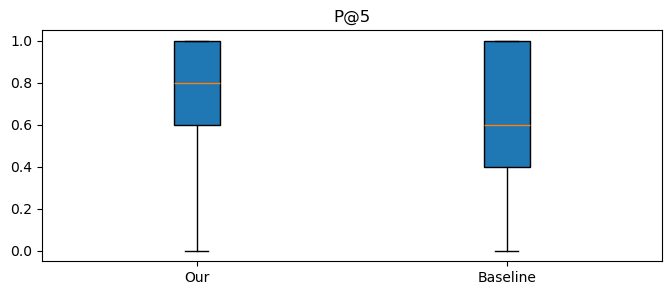

T-test: statistic = 3.289666981079619, p = 0.0013621670740319007


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


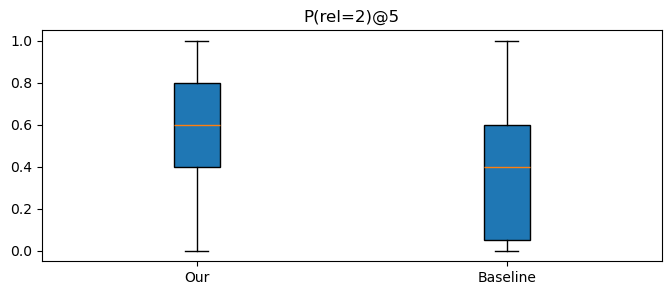

T-test: statistic = 3.6080050067285887, p = 0.0004725228554548332


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


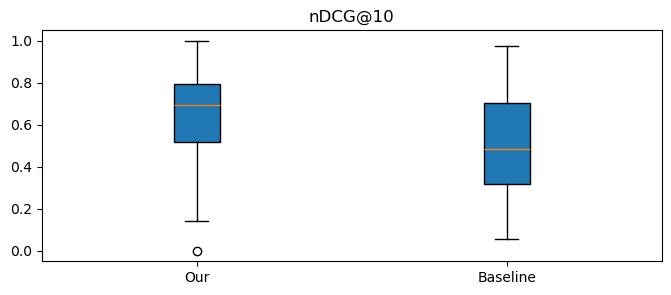

T-test: statistic = 2.3181210454037466, p = 0.022362667967874162


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


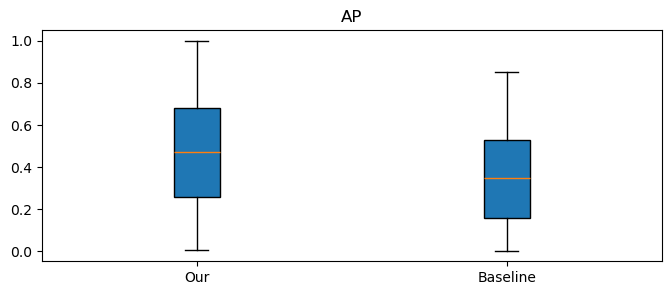

T-test: statistic = 3.0635761539140725, p = 0.0027732117475098863


/tmp/ipykernel_3322723/2796885352.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot([our_values, baseline_values],


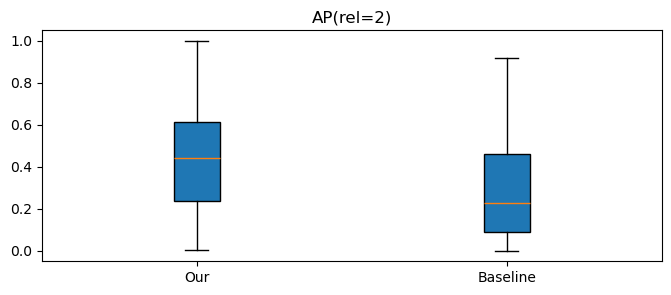

In [65]:
# Prepare data for comparison between neural-enhanced and baseline results
data = [
    (NeuralPat5, BaselinePat5),              # Compare Precision at 5 (P@5)
    (NeuralPRel2at5, BaselinePRel2at5),      # Compare Precision for relevance 2 at 5 (P(rel=2)@5)
    (NeuralnDCGat10, BaselinenDCGat10),      # Compare Normalized Discounted Cumulative Gain at 10 (nDCG@10)
    (NeuralAP, BaselineAP),                  # Compare Average Precision (AP)
    (NeuralAPRel2, BaselineAPRel2)           # Compare Average Precision for relevance 2 (AP(rel=2))
]

# Define the names of the metrics for visualization and analysis
metrics = ["P@5", "P(rel=2)@5", "nDCG@10", "AP", "AP(rel=2)"]

# Generate boxplots and perform statistical tests for the defined metrics
boxplot_and_results(data, metrics)